## Process Optimization - the `Main` code 

### First Batch of Bayesian Optimization based on Experimental Data produced on Sep 30, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [2]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

### Load the experimental data

In [3]:
df_film = pd.read_excel('./ML Perov Data/ML perov data stanford.xlsx', sheet_name='2020_09_22_film')
df_film.columns = ['ML Condition', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
       'Success or Fail', 'Notes']
df_film_20200922 = df_film

df_film = pd.read_excel('./ML Perov Data/ML perov data stanford.xlsx', sheet_name='2020_09_30_film')
df_film.columns = ['ML Condition', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
       'Success or Fail', 'Notes']
df_film_20200930 = df_film

df_film = pd.concat([df_film_20200922, df_film_20200930], ignore_index = True)#.sort_values(by=list(df_film.columns[1:7]))
df_film.iloc[:,:-1]
df_film = df_film[df_film['ML Condition'] != 'Y']
success_conditions = df_film[df_film['Success or Fail']==1]['ML Condition'].values

df_film

ML Condition  Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  \
0             0               155           200                 5000   
1             1               160           225                 3000   
2             2               135           200                 2500   
3             3               150           175                 2000   
4             4               170           275                 4500   
5             5               175           250                 3500   
6             6               140           150                 4000   
7             7               155           225                 4000   
8             8               130           175                 3500   
9             9               135           125                 2500   
10           10               130           250                 4500   
11           11               145           125                 3500   
12           12               145           150                 4500   
13           13               160           275                 3500   
14           14               165           225                 4000   
15           15               125           275                 3000   
16           16               170           175                 5000   
17           17               150           100                 2500   
18           18               140           300                 2000   
19           19               165           125                 3000   
20           20               130           200                 4500   
21           21               135           125                 3500   
22           22               135           150                 2500   
23           23               135           150                 3500   
24           24               135           175                 4000   
25           25               135           175                 4000   
26           26               140           100                 3500   
27           27               140           100                 3500   
28           28               140           100                 4000   
29           29               140           125                 2500   
30           30               140           125                 3500   
31           31               140           150                 3500   
32           32               140           150                 4000   
33           33               145           100                 3500   
34           34               145           100                 4500   
35           35               145           125                 3000   
36           36               145           150                 3500   
37           37               145           150                 4000   
38           38               150           125                 3500   
39           39               150           150                 4500   

    Plamsa Height [cm]  Plasma Gas Flow [L/min]  Plasma DC [%]  \
0                  1.2                       35             50   
1                  0.8                       30             75   
2                  1.0                       25             75   
3                  1.0                       20            100   
4                  1.2                       16             50   
5                  1.2                       25             75   
6                  1.0                       20             75   
7                  0.8                       30             25   
8                  0.8                       25             75   
9                  1.2                       20             25   
10                 1.2                       30             50   
11                 1.0                       25             50   
12                 1.0                       16            100   
13                 0.8                       20            100   
14                 1.0                       25             

In [5]:
df_device = pd.read_excel('./ML Perov Data/ML perov data stanford.xlsx', sheet_name='2020_09_22_device')
df_device.columns = ['ML Condition', 'Sample', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
       'Isc [mA]', 'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_device_20200922 = df_device

df_device = pd.read_excel('./ML Perov Data/ML perov data stanford.xlsx', sheet_name='2020_09_30_device')
df_device = df_device.iloc[:,0:13]
df_device.columns = ['ML Condition', 'Sample', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
       'Isc [mA]', 'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_device_20200930 = df_device

df_device = pd.concat([df_device_20200922, df_device_20200930], ignore_index = True)#.sort_values(by=list(df_film.columns[1:7]))

df_device = df_device[df_device['ML Condition'] != 'Y']
df_device = df_device.sort_values(by=list(df_device.iloc[:,[0,-1]].columns)).drop_duplicates('ML Condition', keep = 'last', ignore_index = True)
df_device = df_device[df_device['ML Condition'].isin(success_conditions)]

df_device

ML Condition                       Sample  Temperature [°C]  Speed [mm/s]  \
0             0               B29R_3-FR0.dat               155           200   
2             2           B18RPALE_4-FR0.dat               135           200   
6             6        B10R_AFTERUP2-FR0.dat               140           150   
8             8         B15R_AFTERUP-FR0.dat               130           175   
9             9  B20RGAPPY_AFTER2UP2-FR0.dat               135           125   
10           10               B13R_5-FR0.dat               130           250   
11           11       B23R_AFTER2UP2-FR0.dat               145           125   
12           12               B25R_7-FR0.dat               145           150   
14           14           B36LPALE_3-FR0.dat               165           225   
15           15      B11L_YELLOWISH2-FR0.dat               125           275   
17           17                 B28R-FR0.dat               150           100   
19           20                          C1L               130           200   
20           21                      B42R_UP               135           125   
21           22                      B46L_UP               135           150   
22           23                         B43R               135           150   
23           24                         C10R               135           175   
24           25                         B38R               135           175   
25           26                       B8R_UP               140           100   
26           27                      B34R_UP               140           100   
27           28                      C32R_UP               140           100   
28           29                         C45R               140           125   
29           30                      C38R_UP               140           125   
30           31                      C27R_UP               140           150   
31           32                      C35R_UP               140           150   
32           33                      C17L_UP               145           100   
33           34                      C19R_UP               145           100   
34           35                      C21R_UP               145           125   
35           36                      C25R_UP               145           150   
36           37                      C26R_UP               145           150   
37           38                      C49R_UP               150           125   
38           39                         C46R               150           150   

    Spray Flow [uL/min]  Plamsa Height [cm]  Plasma Gas Flow [L/min]  \
0                  5000                 1.2                       35   
2                  2500                 1.0                       25   
6                  4000                 1.0                       20   
8                  3500                 0.8                       25   
9                  2500                 1.2                       20   
10                 4500                 1.2                       30   
11                 3500                 1.0                       25   
12                 4500                 1.0                       16   
14                 4000                 1.0                       25   
15                 3000                 0.8                       20   
17                 2500                 1.0                       35   
19                 4500                 1.2                       25   
20                 3500                 1.0                       25   
21                 2500                 1.2                       20   
22                 3500                 1.2                       25   
23                 4000                 1.2                       25   
24                 4000                 1.2                       25   
25                 3500                 1.0                       25   
26                 3500                 1.2                       25   
27

In [6]:
df_previous  = pd.read_excel("./ML Perov Data/Previous Data New Plasma - 20200927.xlsx", sheet_name= "Sheet1")
print(df_previous.columns)
df_previous.columns = ['', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']

df_previous = df_previous.iloc[:,1:]
df_previous

Index(['Unnamed: 0', 'Temp [degC]', 'speed [mm/s]', 'sprayFL [uL/min]',
       'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]', 'Jsc [mA/cm2]',
       'Voc [V]', 'FF [-]', 'Efficiency [%]'],
      dtype='object')


Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
0                145           150                 3000                 1.0   
1                145           150                 3000                 1.0   
2                145           150                 3000                 1.0   
3                145           150                 3000                 1.0   
4                145           150                 3000                 1.0   
..               ...           ...                  ...                 ...   
61               145           100                 3000                 1.0   
62               140           150                 4500                 1.0   
63               140           150                 4500                 1.0   
64               140           150                 4000                 0.8   
65               140           150                 4000                 0.8   

    Plasma Gas Flow [L/min]  Plasma DC [%]  Jsc [mA/cm2]    Voc [V]    FF [-]  \
0                        15            100      0.946349  22.270719  0.736124   
1                        15            100      0.918172  21.633918  0.764603   
2                        15            100      0.919626  21.668702  0.763088   
3                        15            100      0.942140  20.526225  0.740573   
4                        15            100      0.952371  20.491409  0.740810   
..                      ...            ...           ...        ...       ...   
61                       15            100      0.839688  18.364500  0.546522   
62                       15            100      0.983829  21.500242  0.523180   
63                       15            100      0.968943  20.237956  0.555148   
64                       15            100      0.960732  20.521194  0.661844   
65                       15            100      0.936220  19.452934  0.654643   

    Efficiency [%]  
0          15.5145  
1          15.1878  
2          15.2061  
3          14.3216  
4          14.4572  
..             ...  
61          8.4276  
62         11.0666  
63         10.8861  
64         13.0485  
65         11.9225  

[66 rows x 10 columns]

### Set the variable space of process conditions

In [7]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [8]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
                                 ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
                                 ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
                                 ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
                                 ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
                                 ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
                                 ])


### Define the Probabilistic Constrained Bayesian Optimization Loop
- This Optimization loop takes in two contraint functions (one for binary film quality; one for previous device data)
- The data for constraint function is converted into a probablistic constraint (with a scaling factor spec the contraint strength on the acquisition function)

In [9]:
from typing import Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization import AcquisitionOptimizerBase
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition
from emukit.bayesian_optimization.local_penalization_calculator import LocalPenalizationPointCalculator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      MultipointExpectedImprovement,\
                                                      ProbabilityOfFeasibility
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

class ProbabilisticConstraintBayesianOptimizationLoop2(OuterLoop):
    def __init__(self, space: ParameterSpace, model_objective: Union[IModel, IDifferentiable],
                 model_constraint1: Union[IModel, IDifferentiable], 
                 model_constraint2: Union[IModel, IDifferentiable],
                 acquisition: Acquisition = None,
                 update_interval: int = 1, batch_size: int = 1):

        """
        Emukit class that implements a loop for building Bayesian optimization with an unknown constraint.
        For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param space: Input space where the optimization is carried out.
        :param model_objective: The model that approximates the underlying objective function
        :param model_constraint: The model that approximates the unknown constraints
        :param acquisition: The acquisition function for the objective function (default, EI).
        :param update_interval:  Number of iterations between optimization of model hyper-parameters. Defaults to 1.
        :param batch_size: How many points to evaluate in one iteration of the optimization loop. Defaults to 1.
        """

#         if not np.all(np.isclose(model_objective.X, model_constraint.X)):
#             raise ValueError('Emukit currently only supports identical '
#                              'training inputs for the constrained and objective model')
        self.model_objective = model_objective
        self.model_constraint1 = model_constraint1
        self.model_constraint2 = model_constraint2
        
        if acquisition is None:
            acquisition = ExpectedImprovement(model_objective)
        
        acquisition_constraint1 = ScaledProbabilityOfFeasibility(model_constraint1, max_value = 1, min_value = 0.5)
        acquisition_constraint2 = ScaledProbabilityOfFeasibility(model_constraint2, max_value = 1, min_value = 0.8)
        acquisition_constraint = acquisition_constraint1*acquisition_constraint2
        acquisition_constrained = acquisition * acquisition_constraint

        model_updater_objective = FixedIntervalUpdater(model_objective, update_interval)
        model_updater_constraint1 = FixedIntervalUpdater(model_constraint1, update_interval,
                                                        lambda state: state.Y_constraint1)
        model_updater_constraint2 = FixedIntervalUpdater(model_constraint2, update_interval,
                                                        lambda state: state.Y_constraint2)

        acquisition_optimizer = GradientAcquisitionOptimizer(space)
        if batch_size == 1:
            candidate_point_calculator = SequentialPointCalculator(acquisition_constrained, acquisition_optimizer)
        else:
            log_acquisition = LogAcquisition(acquisition_constrained)
            candidate_point_calculator = LocalPenalizationPointCalculator(log_acquisition, acquisition_optimizer,
                                                                          model_objective, space, batch_size)
        loop_state = create_loop_state(model_objective.X, model_objective.Y)
        
        #loop_state = create_loop_state(model_objective.X, model_objective.Y, Y_constraint=model_constraint.Y)

        super(ProbabilisticConstraintBayesianOptimizationLoop2, self).__init__(candidate_point_calculator,
                                                                              [model_updater_objective, model_updater_constraint1,model_updater_constraint2],
                                                                              loop_state)
#     def suggest_next_locations(self):
#         return self.candidate_point_calculator.compute_next_points(self.loop_state)
    
#     def acquisition_evaluate(self, X: loop_sate.X):
#         return acquisition.evaluate(X), acquisition_constraint.evaluate(X), acquisition_constrained.evaluate(X)


In [10]:
from typing import Tuple, Union
import scipy.stats
import numpy as np
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable

class ScaledProbabilityOfFeasibility(Acquisition):

    def __init__(self, model: Union[IModel, IDifferentiable], jitter: float = float(0),
                 max_value: float = float(1), min_value: float = float(0)) -> None:
        """
        This acquisition computes for a given input point the probability of satisfying the constraint
        C<0. For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param model: The underlying model that provides the predictive mean and variance for the given test points
        :param jitter: Jitter to balance exploration / exploitation
        """
        self.model = model
        self.jitter = jitter
        self.max_value = max_value
        self.min_value = min_value

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: numpy array with the probability of satisfying the constraint at the points x.
        """
        mean, variance = self.model.predict(x)
        mean += self.jitter

        standard_deviation = np.sqrt(variance)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        return cdf*(self.max_value-self.min_value)+self.min_value

    def evaluate_with_gradients(self, x: np.ndarray) -> Tuple:
        """
        Computes the  probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: tuple of numpy arrays with the probability of satisfying the constraint at the points x 
        and its gradient.
        """
        mean, variance = self.model.predict(x)
        standard_deviation = np.sqrt(variance)

        dmean_dx, dvariance_dx = self.model.get_prediction_gradients(x)
        dstandard_devidation_dx = dvariance_dx / (2 * standard_deviation)

        mean += self.jitter
        u = - mean / standard_deviation
        pdf = scipy.stats.norm.pdf(0, mean, standard_deviation)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        dcdf_dx = - pdf * (dmean_dx + dstandard_devidation_dx * u)

        return cdf*(self.max_value-self.min_value)+self.min_value, dcdf_dx

    @property
    def has_gradients(self):
        return isinstance(self.model, IDifferentiable)

### Run GP Regression on the Experimental Data
- Experimental device data for round 0 initial sampling and round 1 experiments: device efficiency
- Experimental film data for round 0 initial sampling and round 1 experiments: binary film quality
- Previous experiment data of the "new plasma" nozzle: device efficiency

In [11]:
np.random.seed(10)

from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

x_init = x_normalizer(df_device.iloc[:,2:8].values)
y_init = np.transpose([df_device.iloc[:,-1].values])
xc_init = x_normalizer(df_film.iloc[:,1:-2].values)
yc_init = np.transpose([df_film.iloc[:,-2].values])
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

Xc2 = x_normalizer(df_previous.iloc[:,0:6].values)
Yc2 = np.transpose([df_previous.iloc[:,-1].values])

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(1e-1, 1)
ker.variance.constrain_bounded(1e-1, 1000.0)
ker += GPy.kern.White(input_dim = input_dim)
model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
model_gpy.Gaussian_noise.variance = 1**2
model_gpy.Gaussian_noise.variance.fix()
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model = GPyModelWrapper(model_gpy)

input_dim = len(Xc[0])
ker = GPy.kern.RBF(input_dim = input_dim, ARD = True)
ker.lengthscale.constrain_bounded(1e-1, 10)#upper bound set to 1 
ker.variance.constrain_bounded(1e-1, 1000.0) 
ker += GPy.kern.White(input_dim = input_dim)
yc_offset = 0.5 # constraint acquisition computes the probability of <0
gpy_constraint_model = GPRegression(Xc, -(Yc-yc_offset), ker) #Emukit is a minimization tool; need to make Y negative;
gpy_constraint_model.randomize()
gpy_constraint_model.optimize_restarts(num_restarts=20,verbose =False, messages=False) 
constraint_model1 = GPyModelWrapper(gpy_constraint_model)

input_dim = len(Xc2[0])
ker = GPy.kern.RBF(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(0.5, 1)#avoid overfitting; use a large lower bound
ker.variance.constrain_bounded(1e-1, 1000.0)
ker += GPy.kern.White(input_dim = input_dim)
yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of <0
gpy_constraint_model2 = GPRegression(Xc2 , -(Yc2-yc2_offset), ker) #Emukit is a minimization tool; need to make Y negative;
gpy_constraint_model2.randomize()
gpy_constraint_model2.optimize_restarts(num_restarts=20,verbose =False, messages=False)
constraint_model2 = GPyModelWrapper(gpy_constraint_model2)


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance


##### Check the performance of the regression model

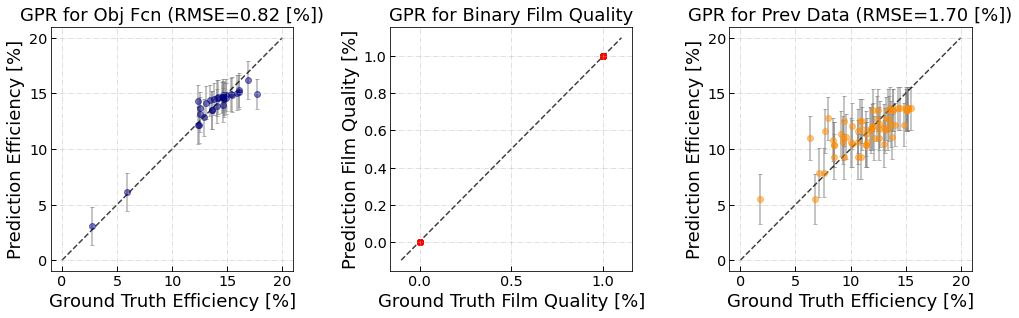

In [12]:
f_obj =  objective_model.model.predict
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

yc_pred, yc_uncer = f_cons1(Xc)
yc_pred = -yc_pred[:,-1]+yc_offset
yc_uncer = np.sqrt(yc_uncer[:,-1])

yc2_pred, yc2_uncer = f_cons2(Xc2)
yc2_pred = -yc2_pred[:,-1]+yc2_offset
yc2_uncer = np.sqrt(yc2_uncer[:,-1])


from sklearn.metrics import mean_squared_error
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 18
lims1 = (0, 20)
axes[0].scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
title = 'GPR for Obj Fcn' + " (RMSE=%.2f" % rmse_value+' [%])'
axes[0].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[0].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[0].set_title(title, fontsize = fs)

lims2 = (-.1, 1.1)
axes[1].scatter(Yc[:,-1], yc_pred, alpha = 0.6, edgecolor = 'r', c = 'r')
axes[1].errorbar(Yc[:,-1], yc_pred, yerr = yc_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)

axes[1].plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
title = 'GPR for Binary Film Quality'
axes[1].set_xlabel('Ground Truth Film Quality [%]', fontsize = fs)
axes[1].set_ylabel('Prediction Film Quality [%]', fontsize = fs)
axes[1].set_title(title, fontsize = fs)


lims3 = (0, 17)
axes[2].scatter(Yc2[:,-1], yc2_pred, alpha = 0.5, c = 'darkorange', edgecolor = 'darkorange')
axes[2].errorbar(Yc2[:,-1], yc2_pred, yerr = yc2_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[2].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Yc2[:,-1], yc2_pred))
title = 'GPR for Prev Data' + " (RMSE=%.2f" % rmse_value+' [%])'

axes[2].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[2].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[2].set_title(title, fontsize = fs)

        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

mse = mean_squared_error
mse_all = mse(Y[:,-1], y_pred)
print ('all rmse: %.4f' % (np.sqrt(mse_all)))

rsquared_all = r2_score(Y[:,-1], y_pred)
print ('all R^2: %.4f' % (rsquared_all))

sprman_all = spearmanr(Y[:,-1], y_pred)
print ('all spearman: %.4f' % (sprman_all[0]))

all rmse: 0.8164
all R^2: 0.9164
all spearman: 0.9073


### Start the First Run of the Batch-mode Bayesian Optimization 

In [22]:
## Expeceted Improvement (EI)
#acquisition = ExpectedImprovement(objective_model, jitter=.1)
## Lower Confidence Bound (LCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

# fully integreated acquisition
# acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.1)
# acquisition_generator = lambda m: NegativeLowerConfidenceBound(m, beta = 1)
# acquisition_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
# acquisition = acquisition_integrated

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size = 22)#batchsize>20 to account for duplication

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)
X_new = x_normalizer(get_closest_array(x_denormalizer(X_new)))

f_obj =  objective_model.model.predict       
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print('total condition no.:', len(Xc))
print('total device no.:', len(bayesopt_cons_pr.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))))


df_Xnew = pd.DataFrame(get_closest_array(x_denormalizer(X_new)), columns = df_film.columns[1:7])
df_all = pd.concat([df_film.iloc[:,1:7], df_Xnew])#.sort_values(by=list(df_film.columns[1:7]))
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[len(df_film):len(df_film)+20]
df_Xnew = df_Xnew.sort_values(by=list(df_film.columns[1:7]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df_film)
df_Xnew

total condition no.: 40
total device no.: 32
maximum Y (PCE [%]):  17.7


Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
40             135.0         100.0               4500.0                 1.2   
41             140.0         100.0               3000.0                 1.0   
42             140.0         125.0               4500.0                 1.2   
43             140.0         150.0               4000.0                 0.8   
44             140.0         150.0               5000.0                 1.0   
45             140.0         200.0               4000.0                 1.0   
46             140.0         250.0               5000.0                 1.2   
47             145.0         150.0               4000.0                 1.2   
48             145.0         150.0               5000.0                 1.2   
49             145.0         175.0               5000.0                 1.2   
50             150.0         100.0               5000.0                 1.2   
51             150.0         200.0               4500.0                 1.0   
52             155.0         125.0               4500.0                 0.8   
53             155.0         150.0               2500.0                 0.8   
54             155.0         150.0               3000.0                 1.0   
55             155.0         175.0               3500.0                 1.2   
56             155.0         200.0               3500.0                 0.8   
57             155.0         225.0               4500.0                 1.2   
58             160.0         150.0               4500.0                 1.0   
59             165.0         175.0               3500.0                 1.0   

    Plasma Gas Flow [L/min]  Plasma DC [%]  
40                     20.0           25.0  
41                     20.0           50.0  
42                     20.0           25.0  
43                     20.0           75.0  
44                     20.0           50.0  
45                     20.0           25.0  
46                     25.0           25.0  
47                     20.0           25.0  
48                     20.0           25.0  
49                     15.0           25.0  
50                     15.0           50.0  
51                     20.0           50.0  
52                     20.0           50.0  
53                     20.0           50.0  
54                     20.0           50.0  
55                     15.0           50.0  
56                     15.0           50.0  
57                     20.0           50.0  
58                     15.0           50.0  
59                     20.0           25.0

In [23]:
X_new = x_normalizer(df_Xnew.values)

y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new
y_uncer_new = np.sqrt(y_uncer_new)

acq_produc = f_cons_acq(X_new)
acq_fcn = f_raw_acq(X_new)
acq_cons = f_cons_pr(X_new)

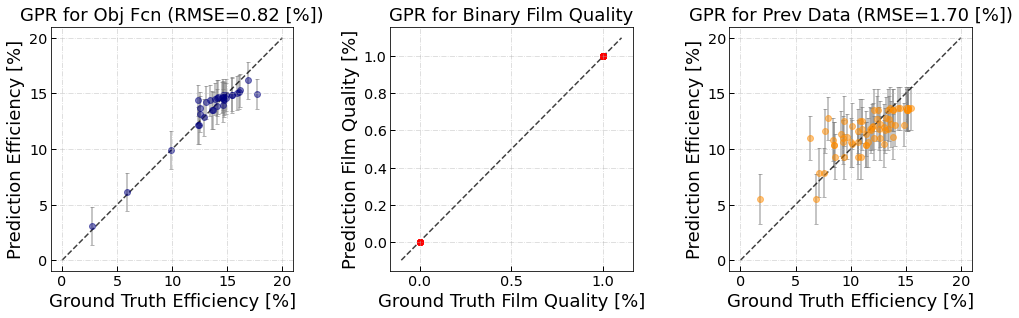

In [24]:
f_obj =  objective_model.model.predict
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

yc_pred, yc_uncer = f_cons1(Xc)
yc_pred = -yc_pred[:,-1]+yc_offset
yc_uncer = np.sqrt(yc_uncer[:,-1])

yc2_pred, yc2_uncer = f_cons2(Xc2)
yc2_pred = -yc2_pred[:,-1]+yc2_offset
yc2_uncer = np.sqrt(yc2_uncer[:,-1])


from sklearn.metrics import mean_squared_error
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 18
lims1 = (0, 20)
axes[0].scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
title = 'GPR for Obj Fcn' + " (RMSE=%.2f" % rmse_value+' [%])'
axes[0].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[0].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[0].set_title(title, fontsize = fs)

lims2 = (-.1, 1.1)
axes[1].scatter(Yc[:,-1], yc_pred, alpha = 0.6, edgecolor = 'r', c = 'r')
axes[1].errorbar(Yc[:,-1], yc_pred, yerr = yc_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)

axes[1].plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
title = 'GPR for Binary Film Quality'
axes[1].set_xlabel('Ground Truth Film Quality [%]', fontsize = fs)
axes[1].set_ylabel('Prediction Film Quality [%]', fontsize = fs)
axes[1].set_title(title, fontsize = fs)


lims3 = (0, 17)
axes[2].scatter(Yc2[:,-1], yc2_pred, alpha = 0.5, c = 'darkorange', edgecolor = 'darkorange')
axes[2].errorbar(Yc2[:,-1], yc2_pred, yerr = yc2_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[2].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Yc2[:,-1], yc2_pred))
title = 'GPR for Prev Data' + " (RMSE=%.2f" % rmse_value+' [%])'

axes[2].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[2].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[2].set_title(title, fontsize = fs)

        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

#### Quick histogram visualization of the newly suggested process conditions

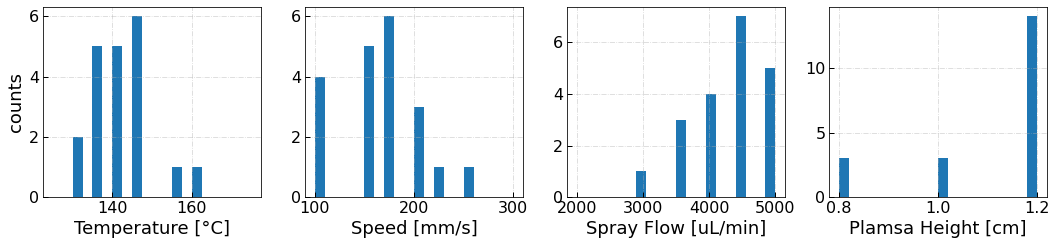

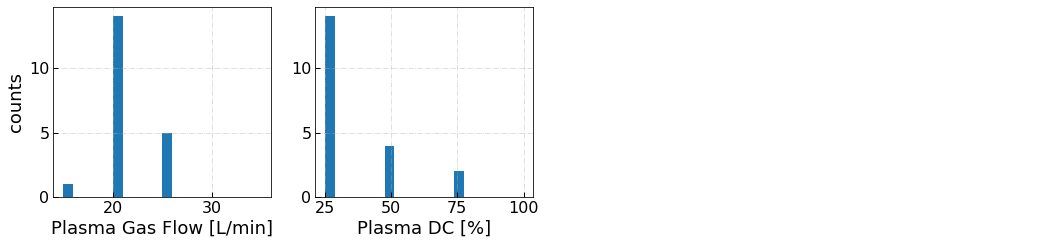

In [24]:
df = df_Xnew
df_cols = df.columns
n_col = 4 # num of columns per row in the figure

for n in np.arange(0, 8, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df.iloc[:,n], bins= 20, range = (min(var_array[n]),max(var_array[n])))####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
            #axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

#### Visualisation of Efficiency vs ML conditions, and Acquisition

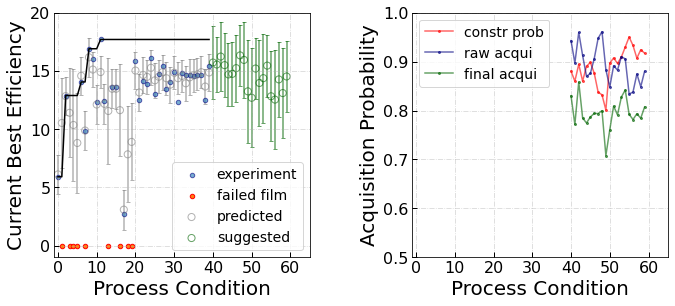

In [25]:
f_obj =  objective_model.model.predict       

device_eff = df_device.sort_values('ML Condition').iloc[:,[0,-1]].values
film_quality = df_film.sort_values('ML Condition').iloc[:,[0,-2]].values

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey = False)
fs = 20
exp_cond = np.transpose(device_eff)[0]
exp_eff = np.transpose(device_eff)[1]

axes[0].scatter(exp_cond, exp_eff, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 0.6, label = 'experiment')

unsuccess_film = np.transpose(film_quality[film_quality[:,-1] ==0])
axes[0].scatter(unsuccess_film[0], unsuccess_film[1],
                #facecolor = 'none',
                edgecolor = 'red',
                s = 20, label = 'failed film')
all_cond = np.concatenate([device_eff, np.transpose(unsuccess_film)])
all_cond = all_cond[np.argsort(all_cond[:,0])]
axes[0].plot(np.transpose(all_cond)[0], np.maximum.accumulate(np.transpose(all_cond)[1]), 
         marker = 'o', ms = 0, c = 'black')

X_sorted = x_normalizer(df_film.sort_values('ML Condition').iloc[:,1:7].values)
y_pred, y_uncer = f_obj(X_sorted)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

axes[0].scatter(np.arange(len(X_sorted)), y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')
axes[0].errorbar(np.arange(len(X_sorted)), y_pred, yerr = y_uncer,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)


y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new[:,-1]
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

axes[0].scatter(np.arange(len(X_new))+len(Xc), y_pred_new,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
axes[0].errorbar(np.arange(len(X_new))+len(Xc), y_pred_new, yerr = y_uncer_new,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'darkgreen', zorder = 0)


axes[0].set_ylabel('Current Best Efficiency', fontsize = 20)
axes[0].set_xlabel('Process Condition', fontsize = 20)

axes[0].set_ylim(-1, 20)
axes[0].set_xlim(-1, 65)
axes[0].set_xticks(np.arange(0,61,10))
axes[0].legend(fontsize = fs*0.7)

axes[1].plot(np.arange(len(X_new))+len(Xc), acq_cons, marker = 'o',
                ms = 2, alpha = 0.6, color = 'red', label = 'constr prob')
axes[1].plot(np.arange(len(X_new))+len(Xc), acq_fcn/20, marker = 'o',
                ms = 2, alpha = 0.6, color = 'navy', label = 'raw acqui')

axes[1].plot(np.arange(len(X_new))+len(Xc), acq_produc/20, marker = 'o',
                ms = 2, alpha = 0.6, color = 'darkgreen', label = 'final acqui')


axes[1].set_ylim(0.5, 1)
axes[1].set_xlim(-1, 65)
axes[1].set_xticks(np.arange(0,65,10))
axes[1].set_ylabel('Acquisition Probability', fontsize = fs)
axes[1].set_xlabel('Process Condition', fontsize = fs)

for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)
plt.legend(fontsize = fs*0.7)
plt.show()

### Visualize the Manifold of the Trained Models

##### Device Efficiency based on IV Measurement Data (after Pre-screened by Visual Inspection)
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

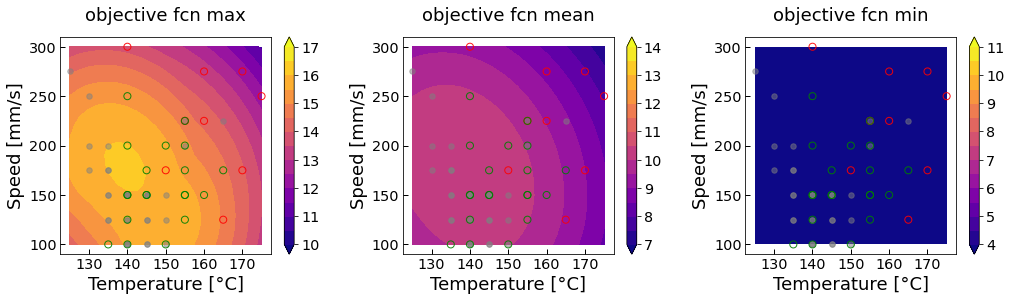

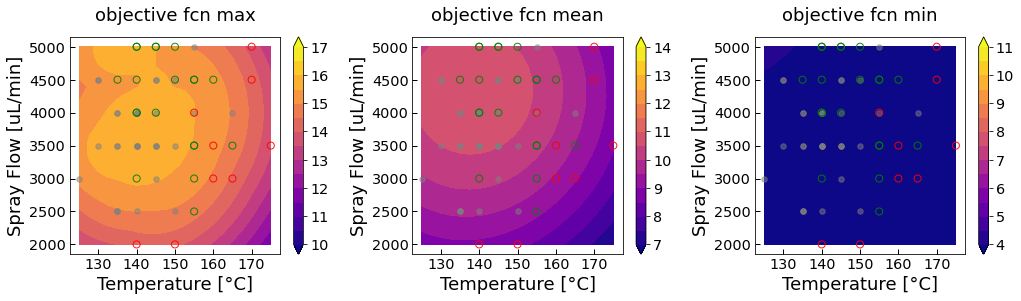

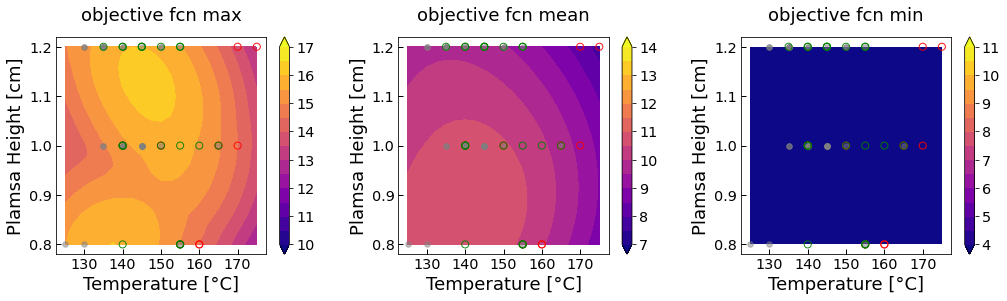

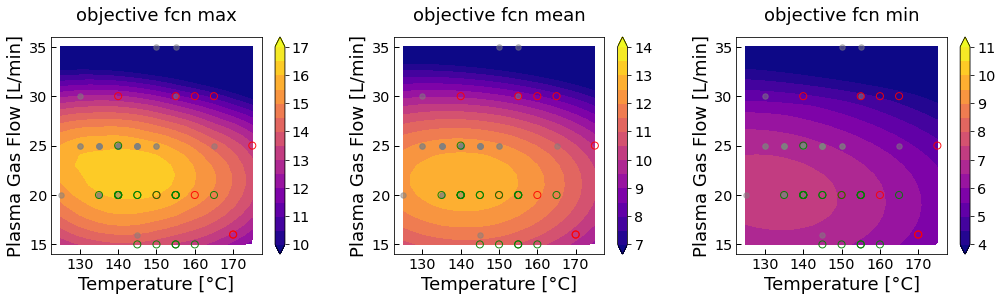

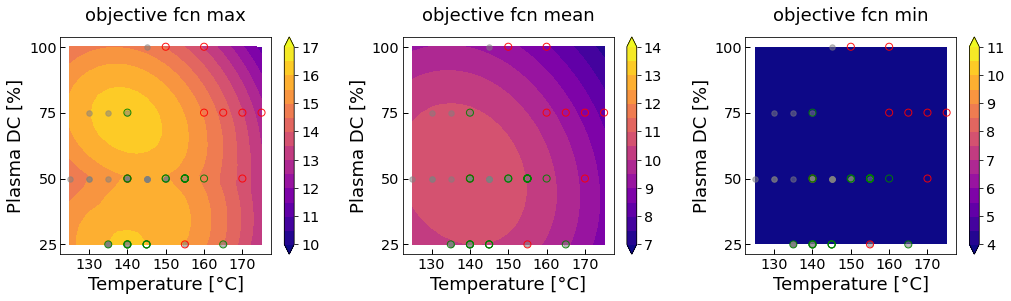

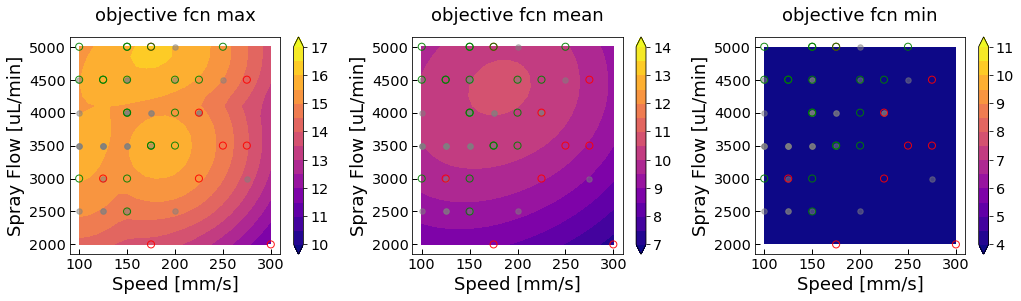

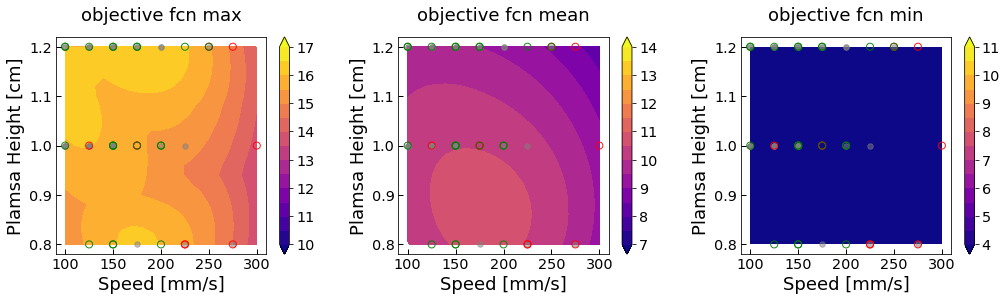

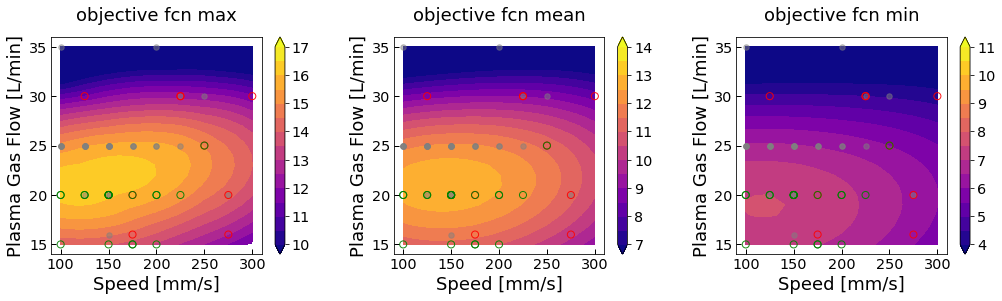

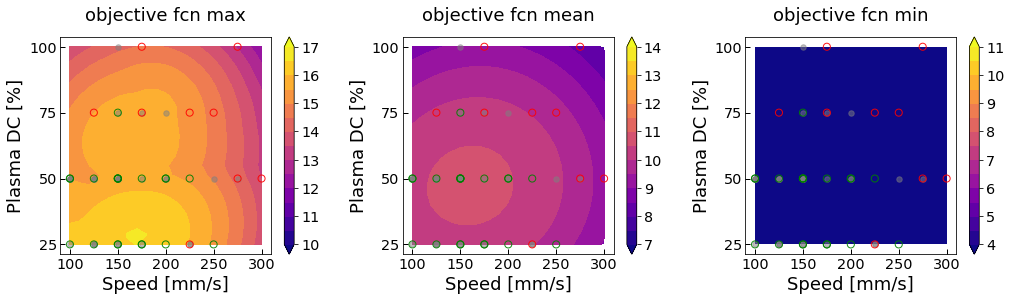

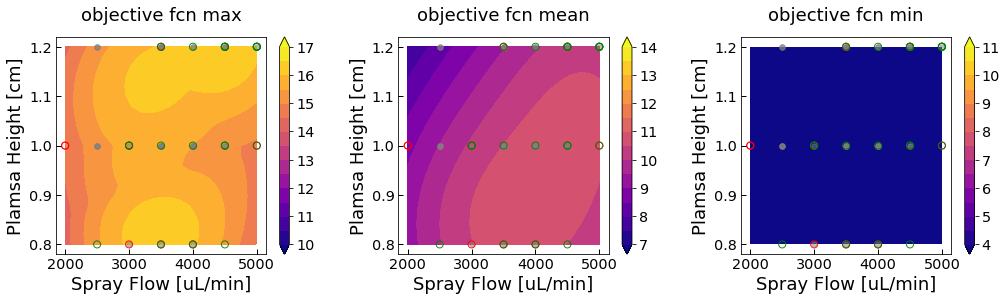

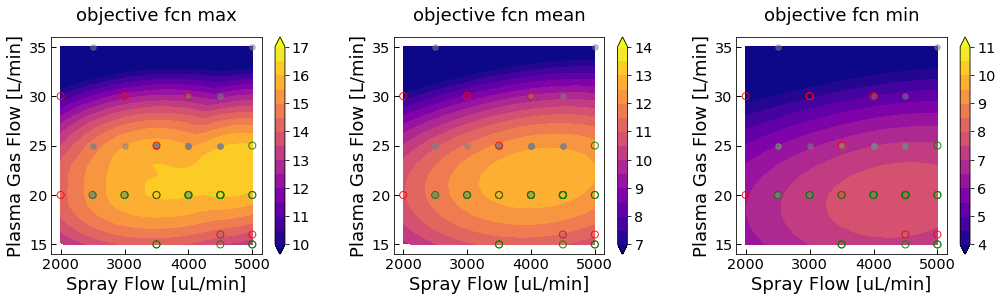

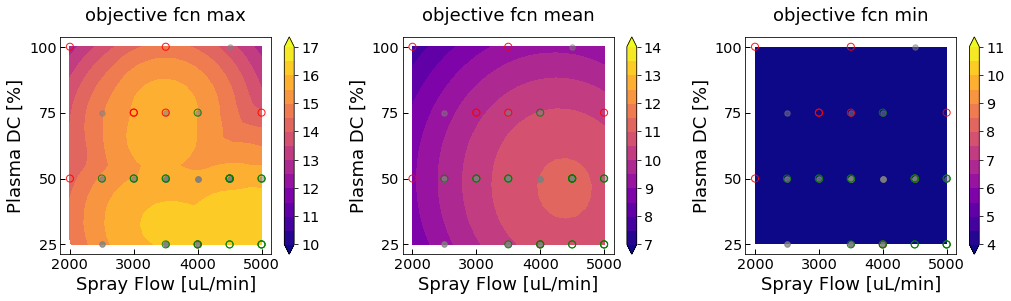

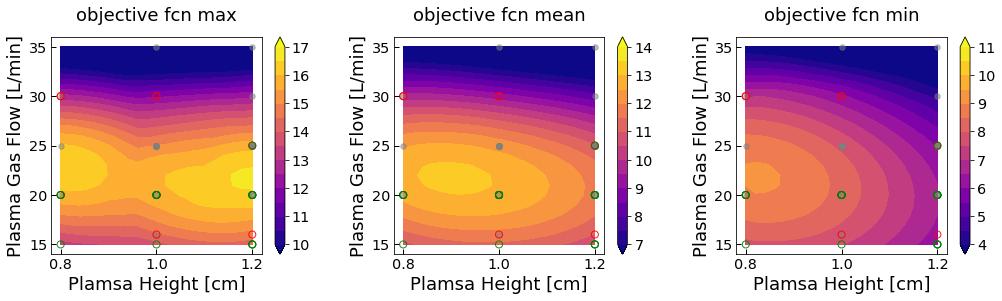

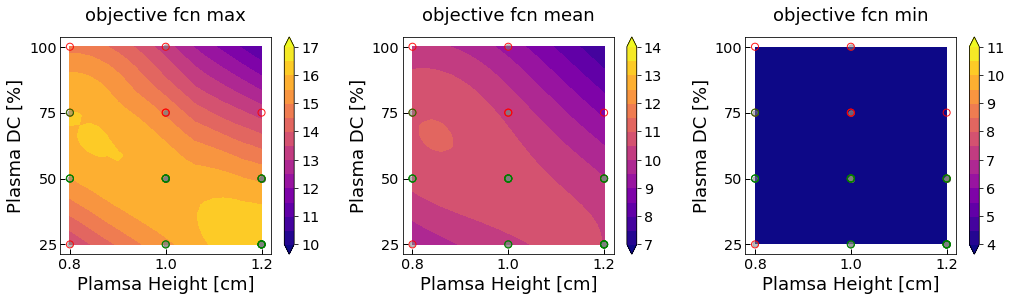

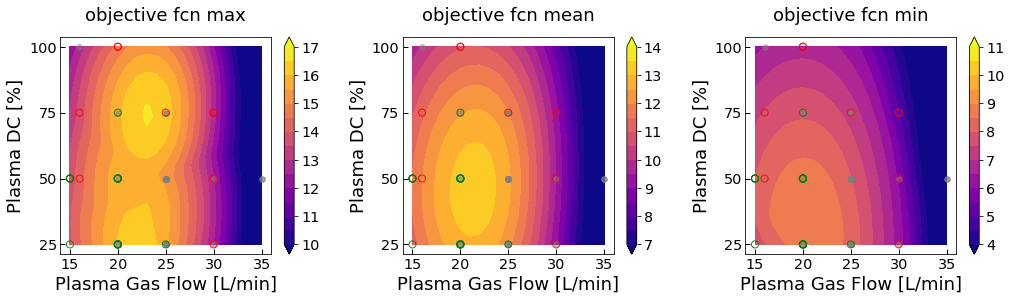

In [26]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_device.iloc[:,2:8].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        
## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj(x_temp)
                y_pred = -y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
                
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
## Contour for Prediction Efficiency Mean
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [10, 7, 4]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):
            
            c_plt1 = ax.contourf(x1, x2, y, levels = np.arange(15)*0.5+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], ## show the conditions with poor film quality
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')

            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1==1:#Speed
                ax.set_xticks([100, 150, 200, 250, 300])
            if ind1==4:#PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2==5:#PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            #ax.grid(True, linestyle='-.')

        axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()
## Contour for Uncertainty        
#         fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         colorbar_offset = [3, 2.5, 2]
#         for ax, c_offset, y in zip(axes, colorbar_offset,
#                                    [y_uncer_max, y_uncer_mean, y_uncer_min]):
            
#             c_plt1 = ax.contourf(x1, x2, y,  levels = np.arange(11)*0.1+c_offset, cmap='plasma', extend = 'both')
#             fig.colorbar(c_plt1, ax= ax)
#             ax.scatter(x_denormalizer(X)[:, ind1], 
#                        x_denormalizer(X)[:, ind2], 
#                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'gray')
#             ax.set_xlabel(str(x_columns[ind1]))
#             ax.set_ylabel(str(x_columns[ind2]))

#             x1_delta = (np.max(x1)-np.min(x1))*0.05
#             x2_delta = (np.max(x2)-np.min(x2))*0.05
#             ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
#             ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)


#         axes[0].set_title('objective uncer max', pad = title_pad)
#         axes[1].set_title('objective uncer mean', pad = title_pad)
#         axes[2].set_title('objective uncer min', pad = title_pad)
#         plt.subplots_adjust(wspace = 0.25)
#         plt.show()

##### Constraint Probablity based Visual Inspection Data of Film Quality 
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

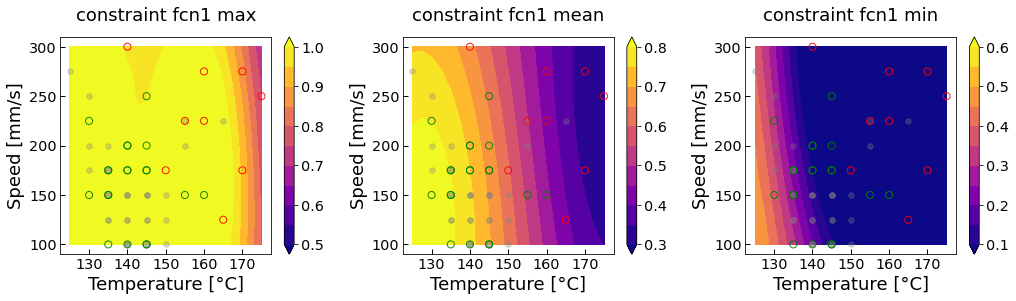

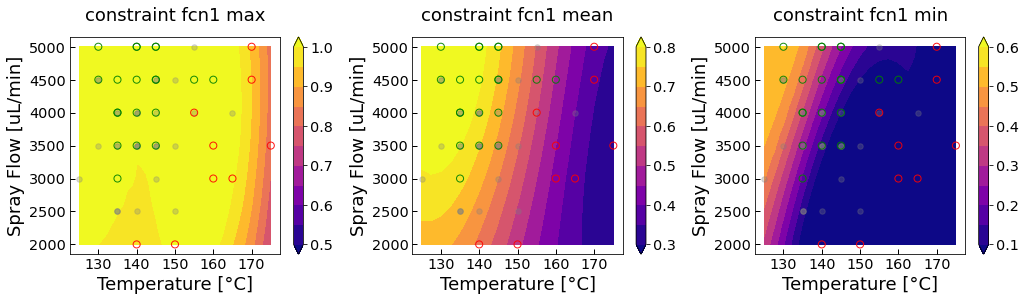

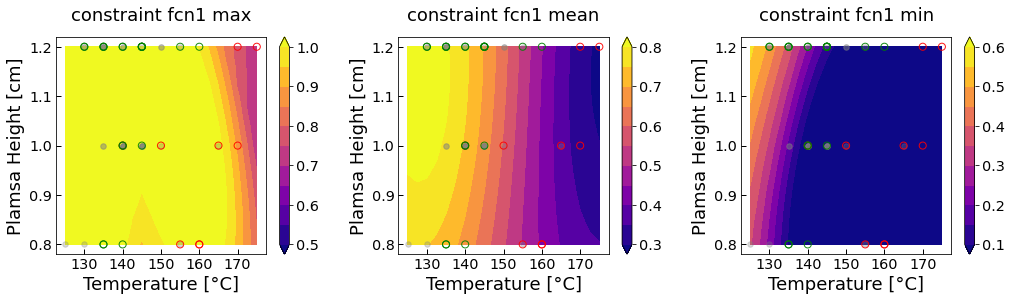

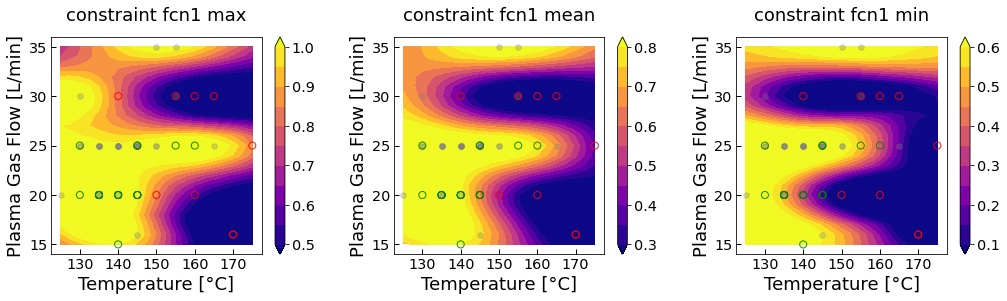

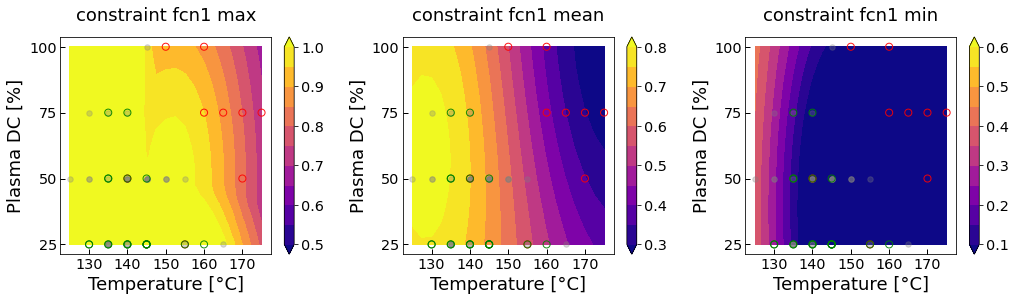

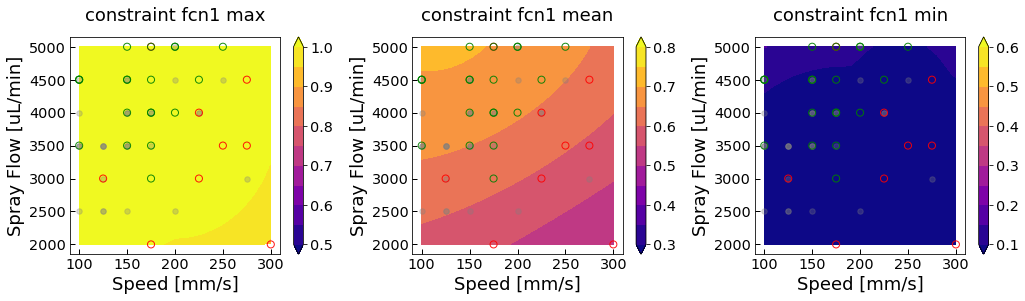

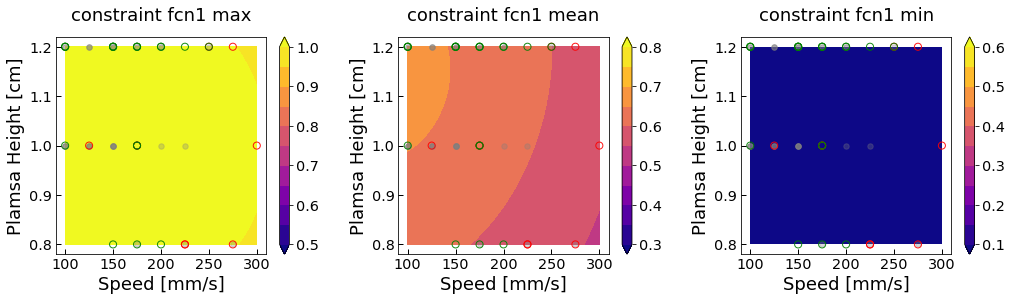

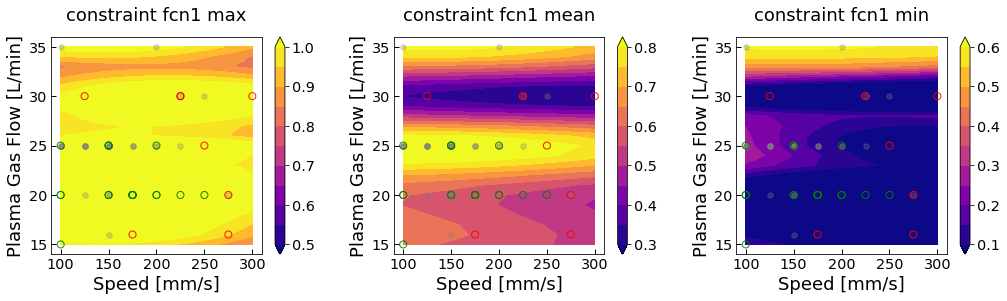

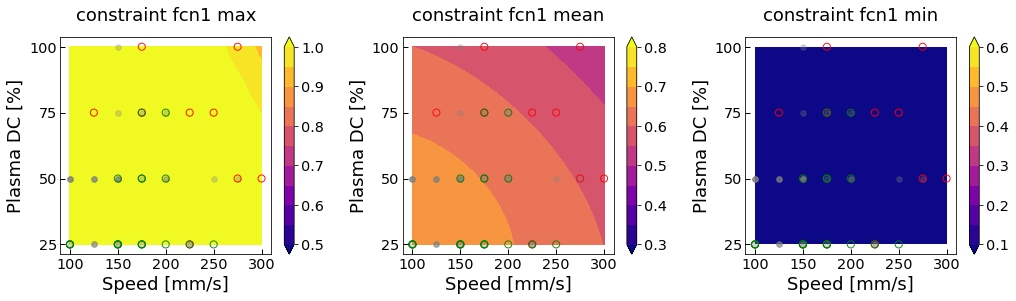

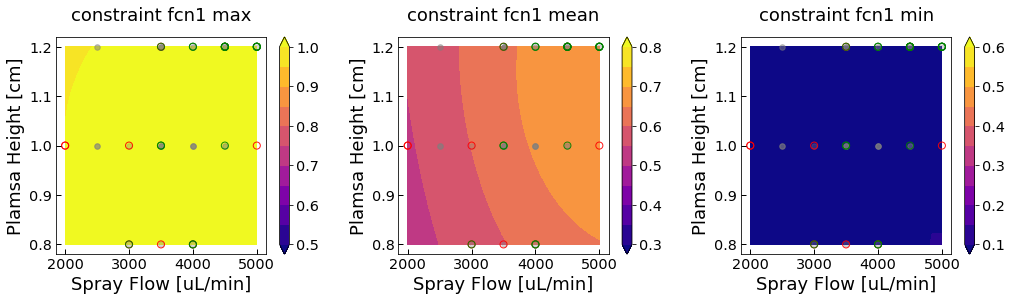

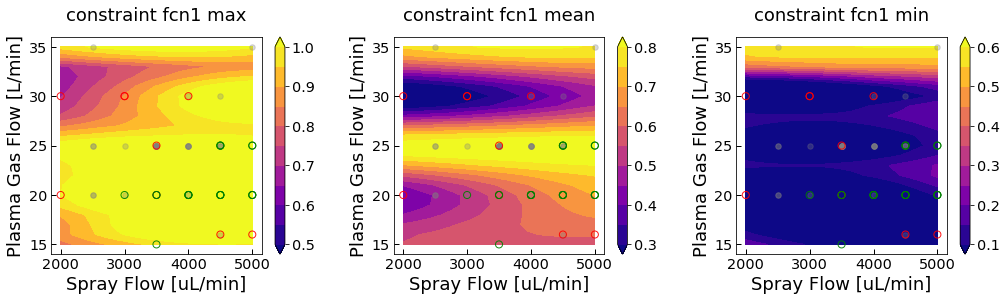

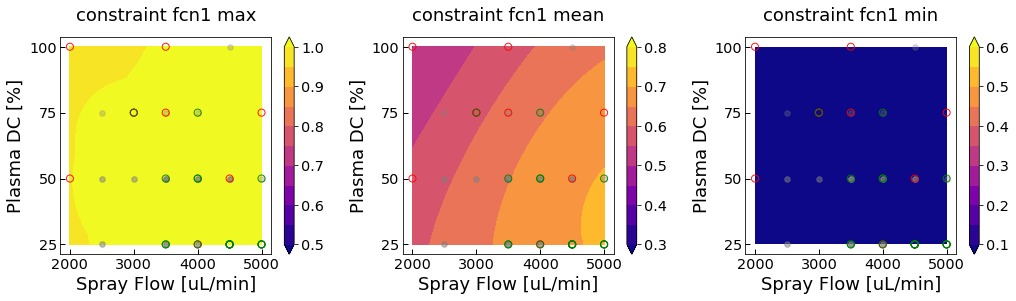

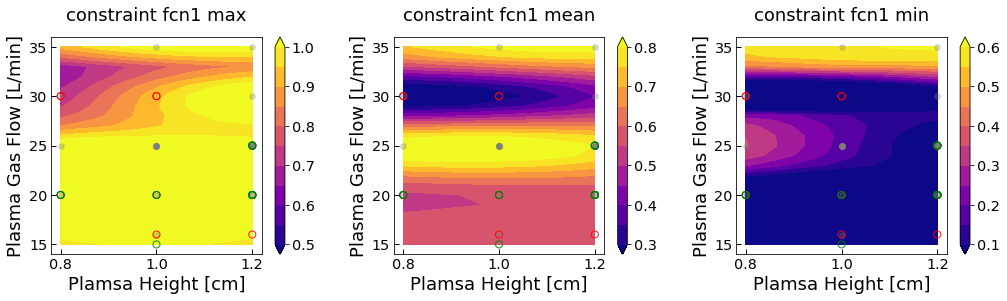

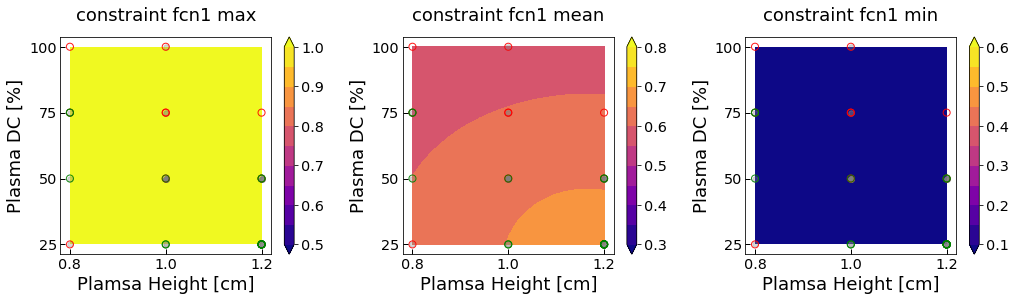

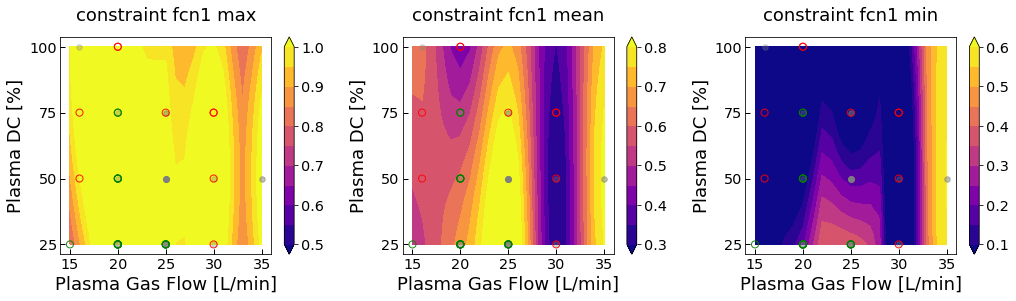

In [27]:
np.random.seed(10)
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr, yc_var = f_cons1(x_temp)
                yc_pr = -yc_pr+yc_offset
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.3, 0.1]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y, levels = np.arange(11)*0.05+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.3, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')     
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            #ax.grid(True, linestyle='-.')
            if ind1==0:#Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1==1:#Speed
                ax.set_xticks([100, 150, 200, 250, 300])
            if ind1==4:#PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2==5:#PlasmaDC
                ax.set_yticks([25, 50, 75, 100])


        axes[0].set_title('constraint fcn1 max', pad = title_pad, fontsize = fs)
        axes[1].set_title('constraint fcn1 mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('constraint fcn1 min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

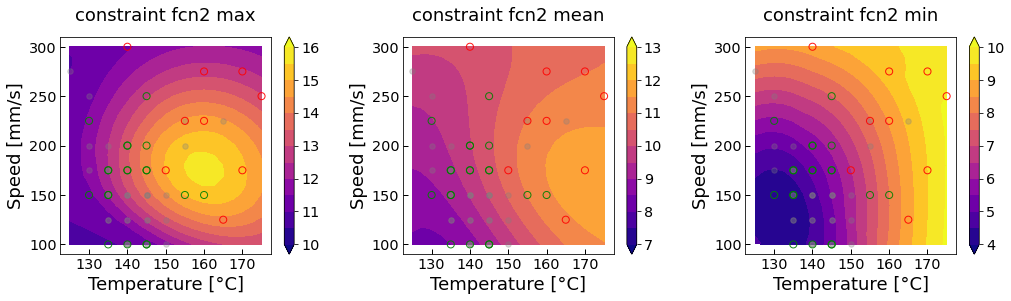

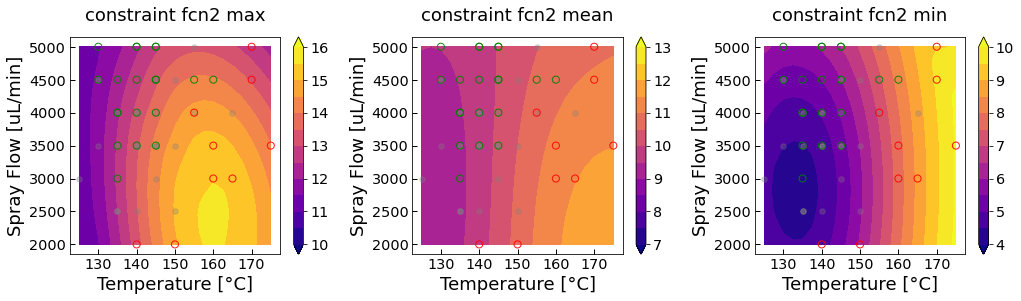

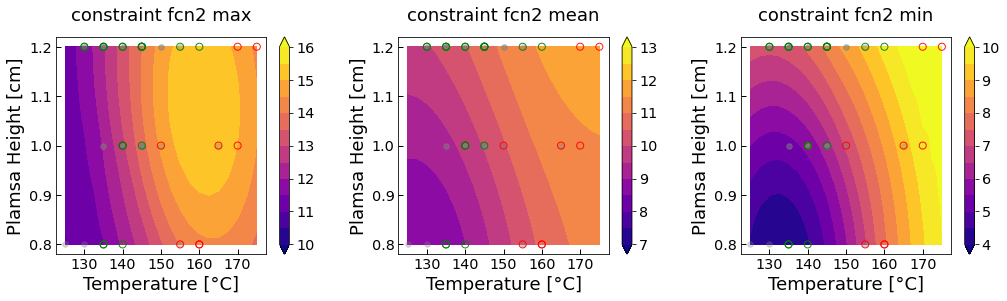

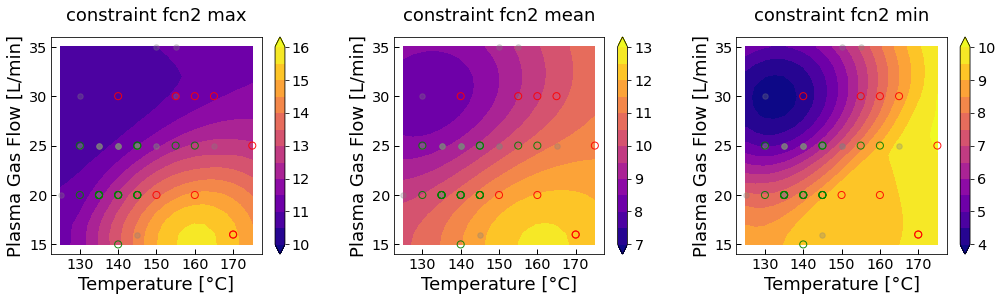

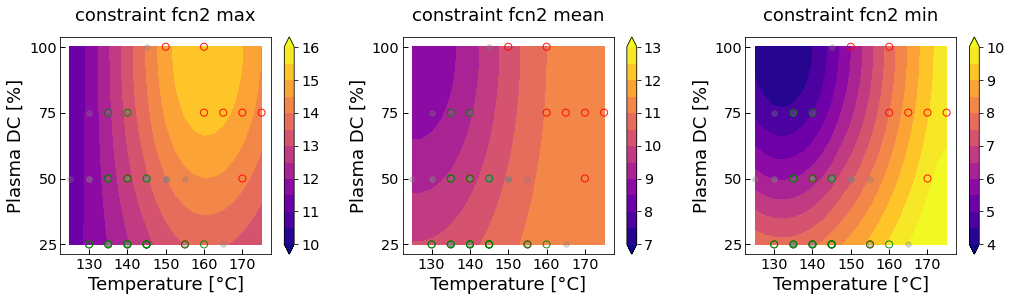

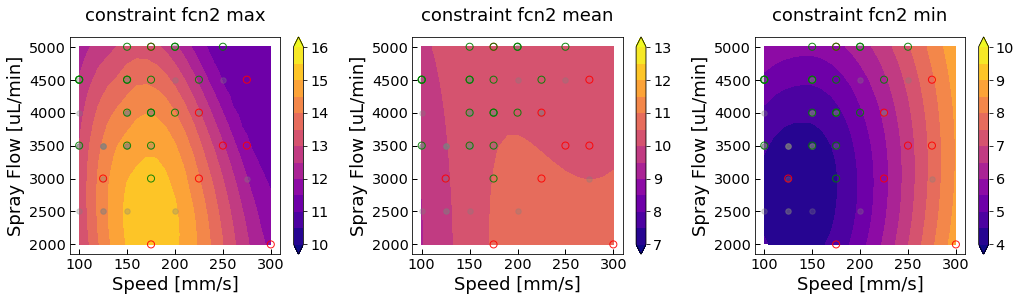

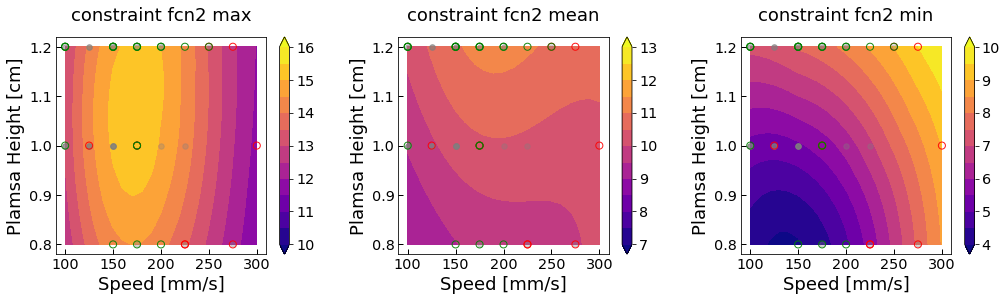

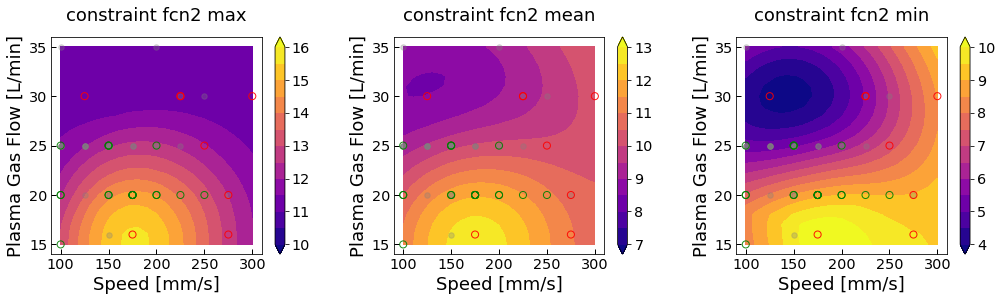

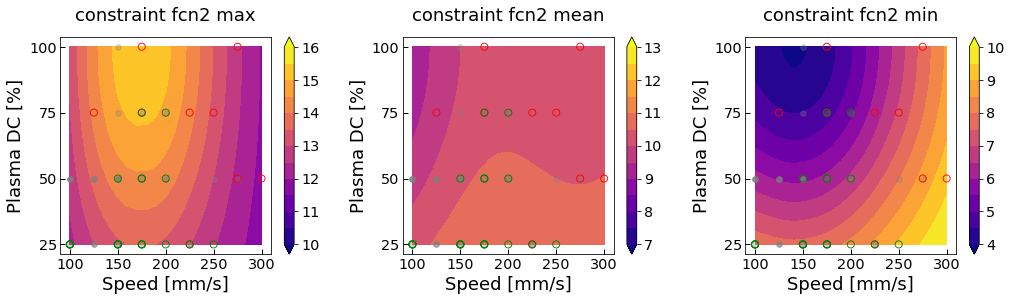

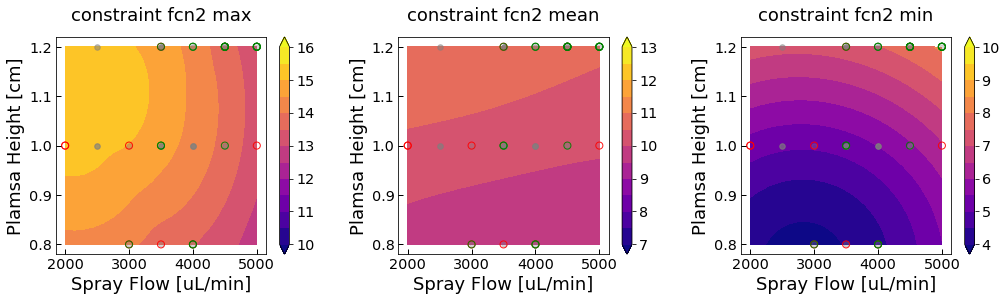

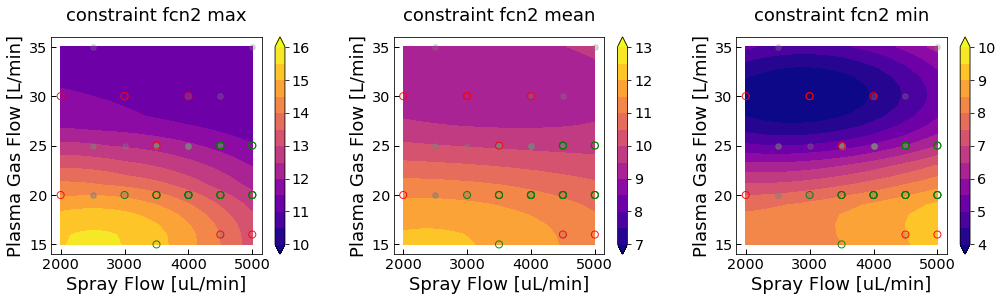

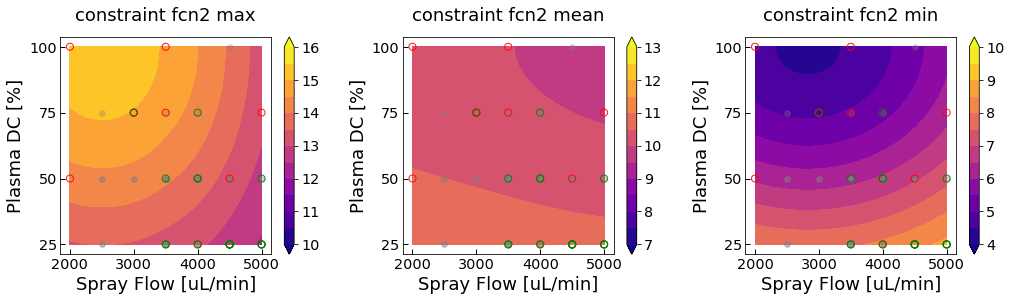

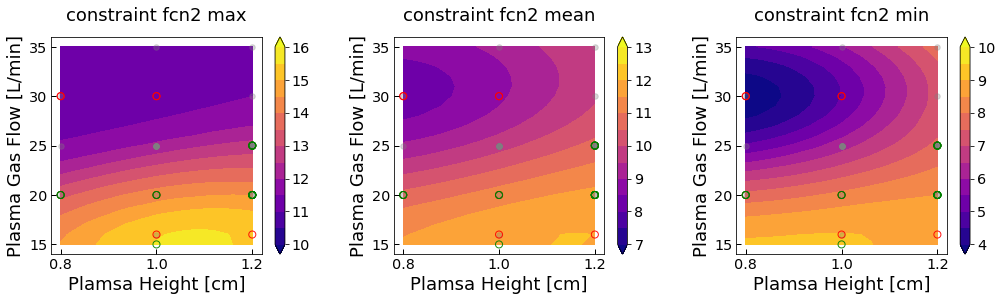

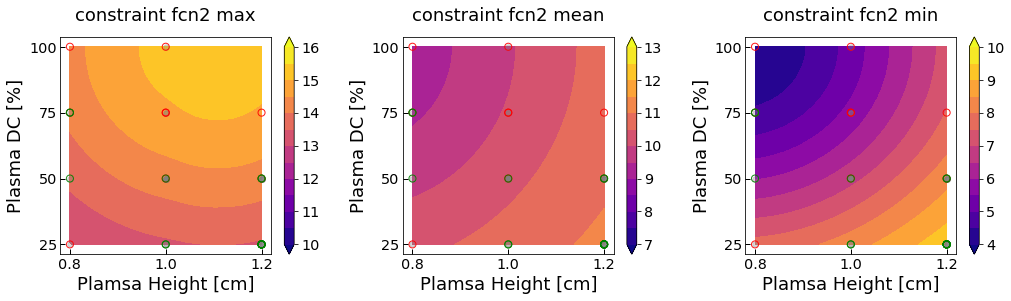

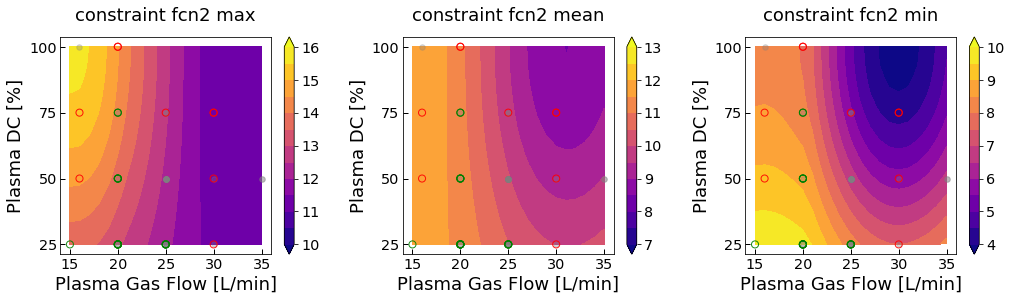

In [28]:
np.random.seed(10)
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr, yc_var = f_cons2(x_temp)
                yc_pr = -yc_pr+yc2_offset
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [10, 7, 4]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y, levels = np.arange(13)*0.5+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.3, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')     
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            #ax.grid(True, linestyle='-.')
            if ind1==0:#Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1==1:#Speed
                ax.set_xticks([100, 150, 200, 250, 300])
            if ind1==4:#PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2==5:#PlasmaDC
                ax.set_yticks([25, 50, 75, 100])


        axes[0].set_title('constraint fcn2 max', pad = title_pad, fontsize = fs)
        axes[1].set_title('constraint fcn2 mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('constraint fcn2 min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

### Acquisition Functions

##### The overall constrained acquisition function

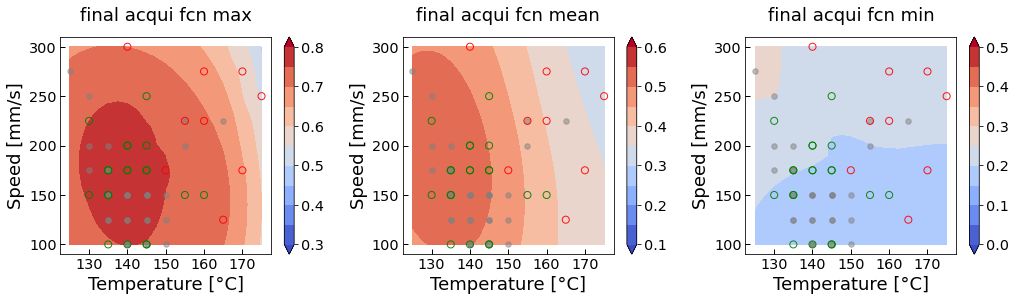

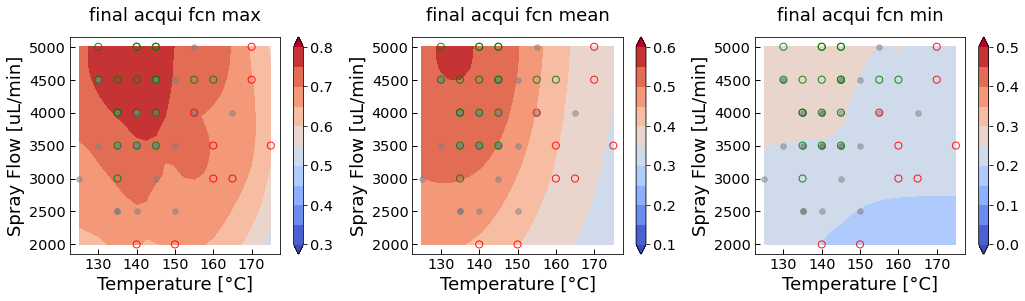

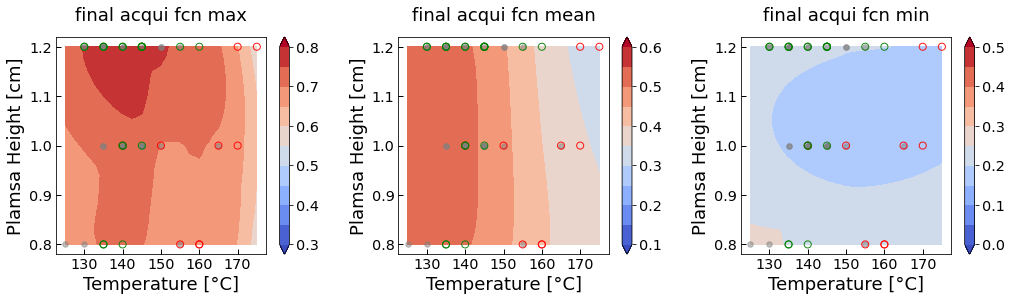

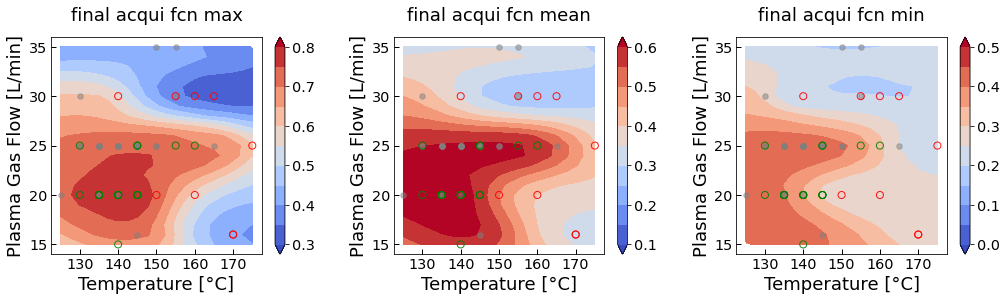

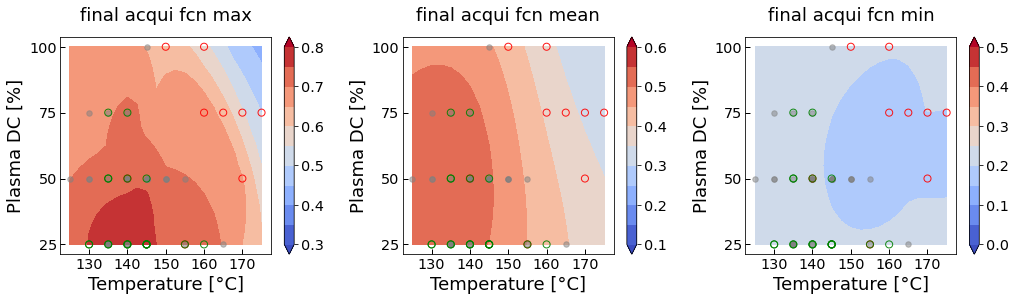

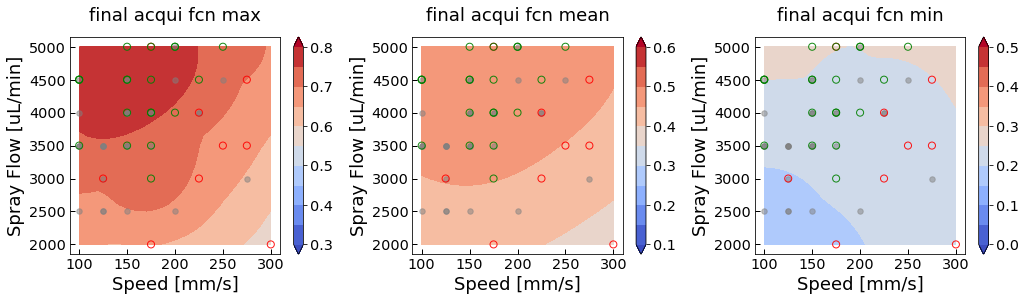

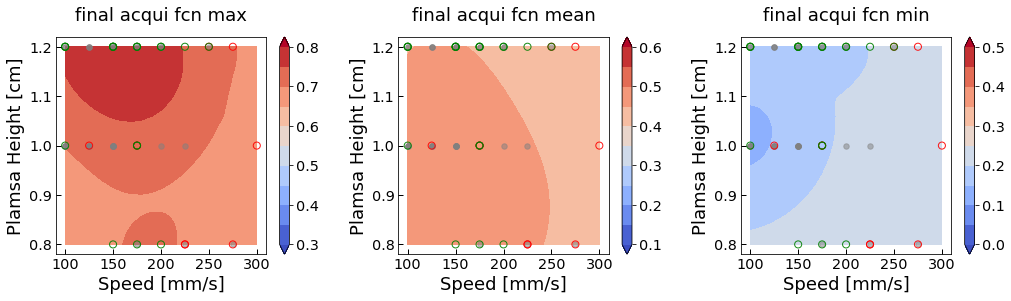

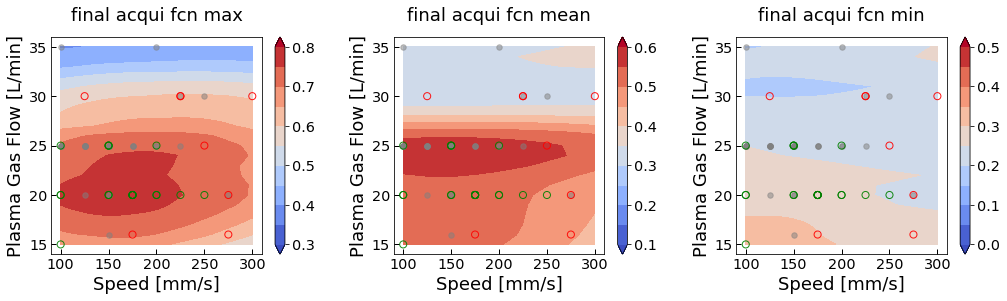

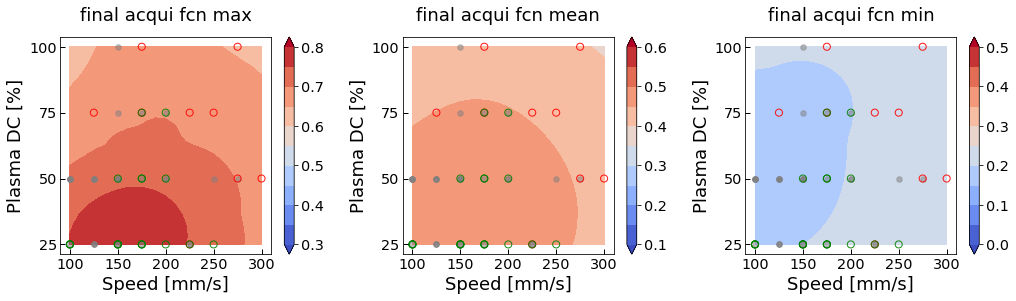

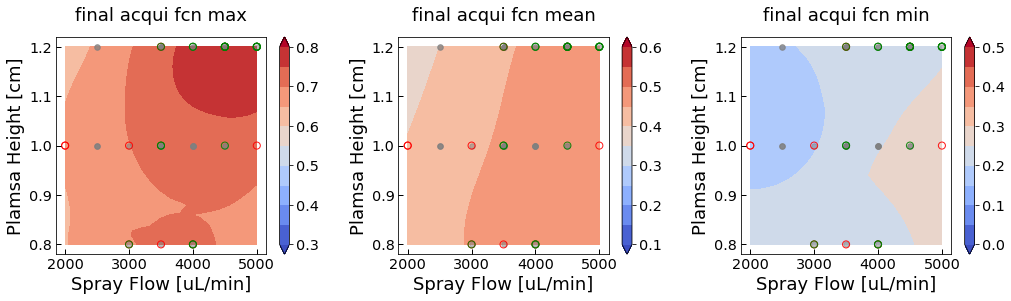

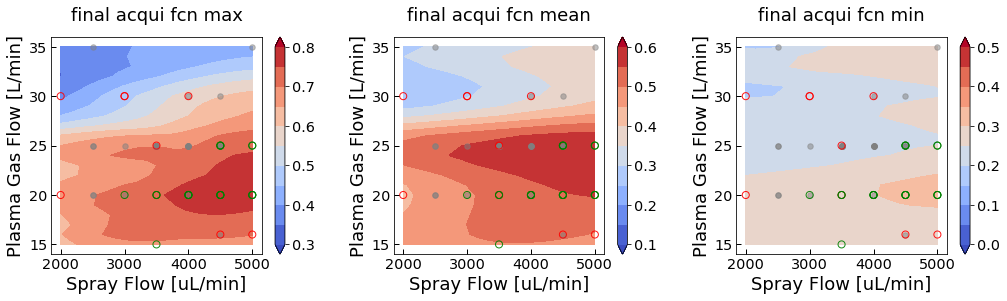

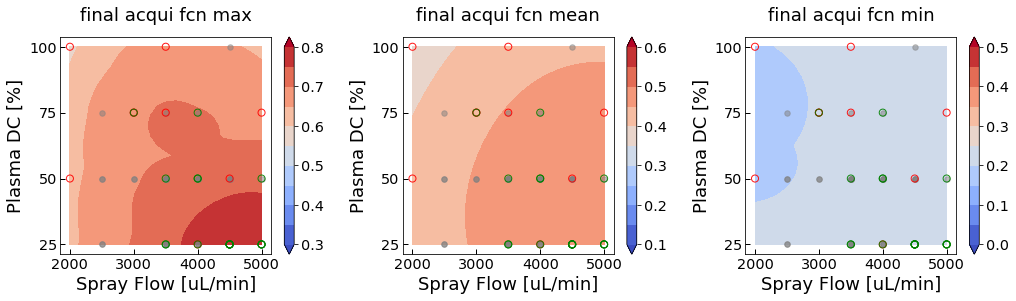

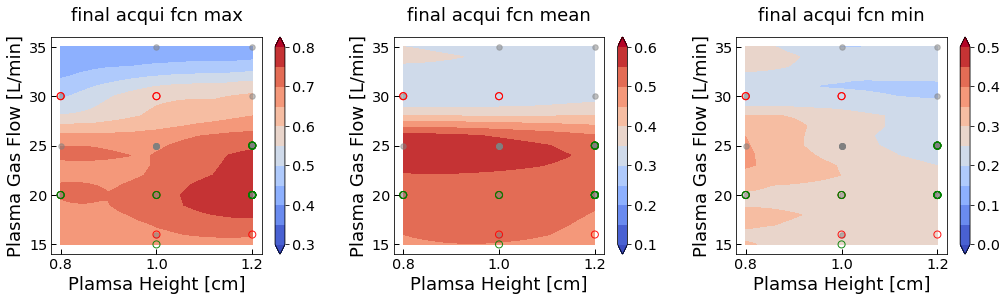

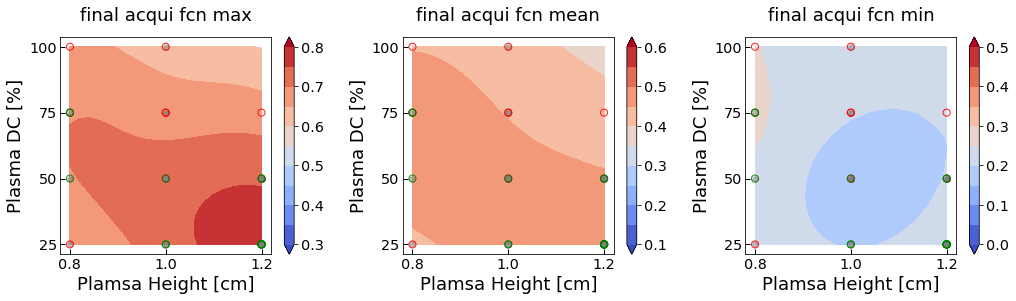

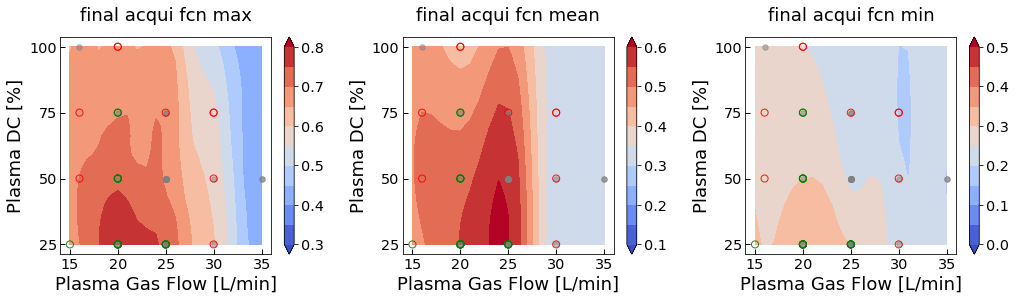

In [29]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_cons_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.3, 0.1, 0.0]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y/22, levels = np.arange(11)*0.05+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                       x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:#Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1==1:#Speed
                ax.set_xticks([100, 150, 200, 250, 300])
            if ind1==4:#PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2==5:#PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            #ax.grid(True, linestyle='-.')
            
            
        axes[0].set_title('final acqui fcn max', pad = title_pad,fontsize = fs)
        axes[1].set_title('final acqui fcn mean', pad = title_pad,fontsize = fs)
        axes[2].set_title('final acqui fcn min', pad = title_pad,fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

##### Original Acquisition Function (based on Objective Function only)

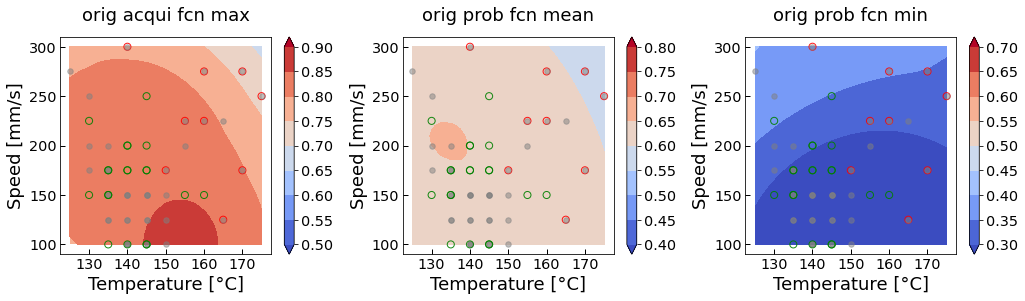

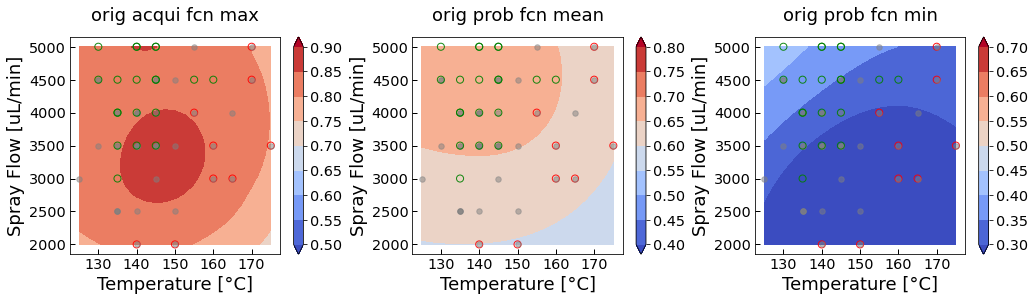

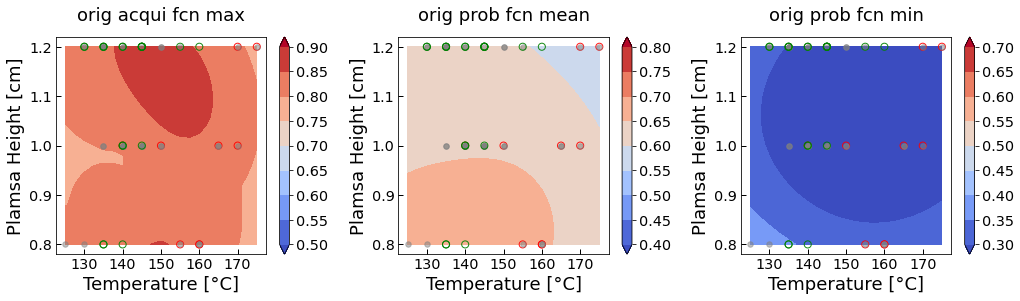

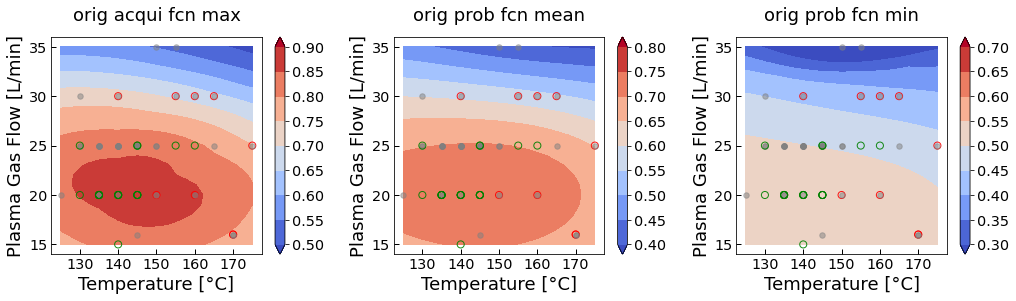

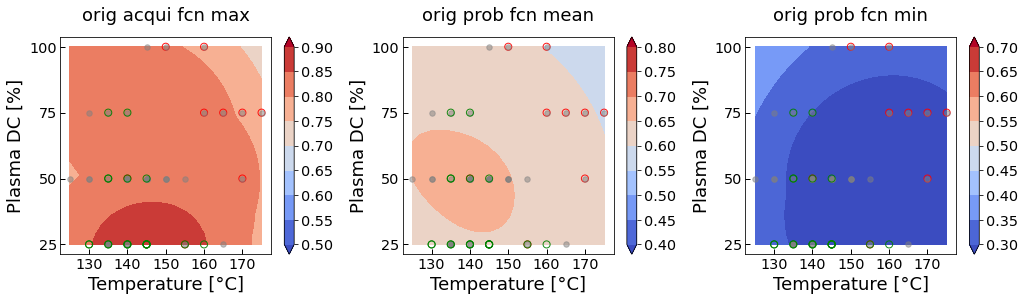

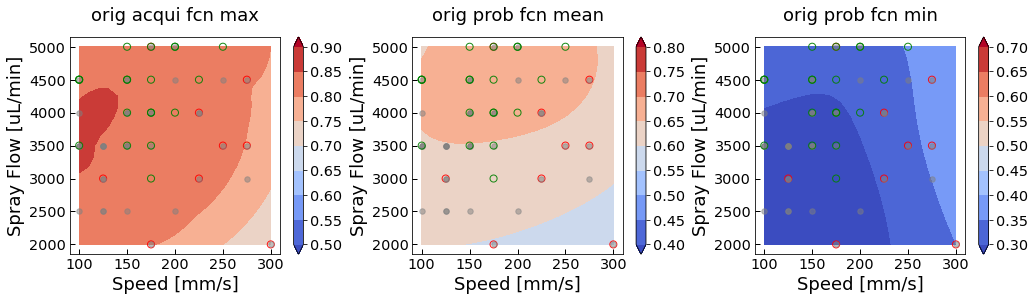

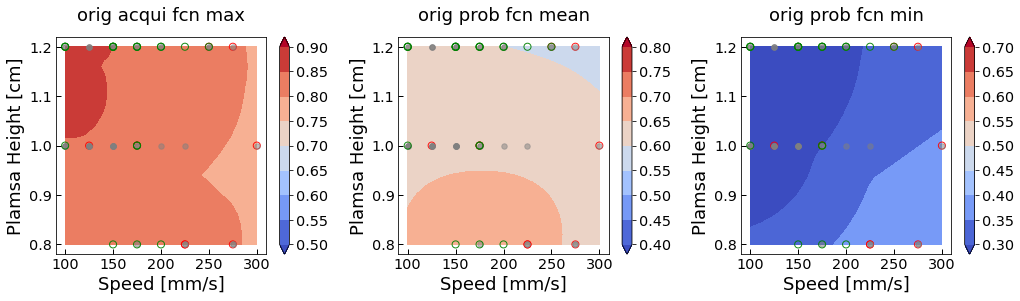

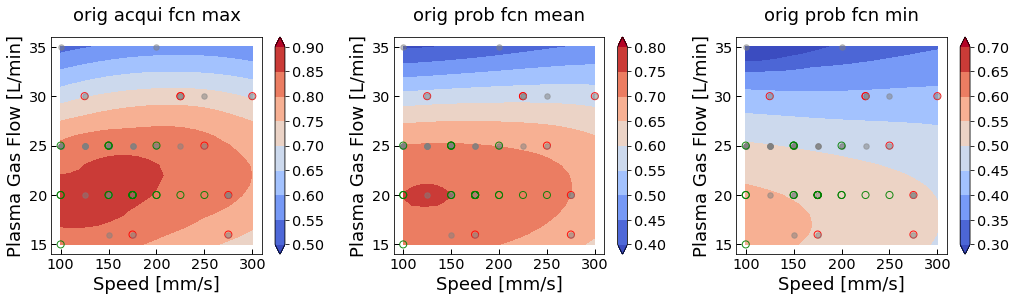

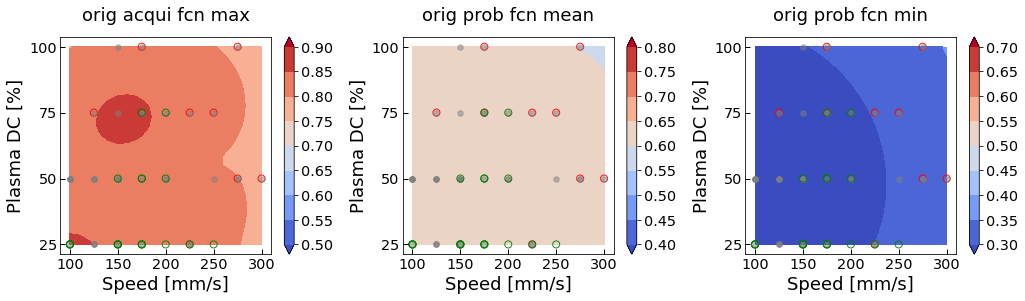

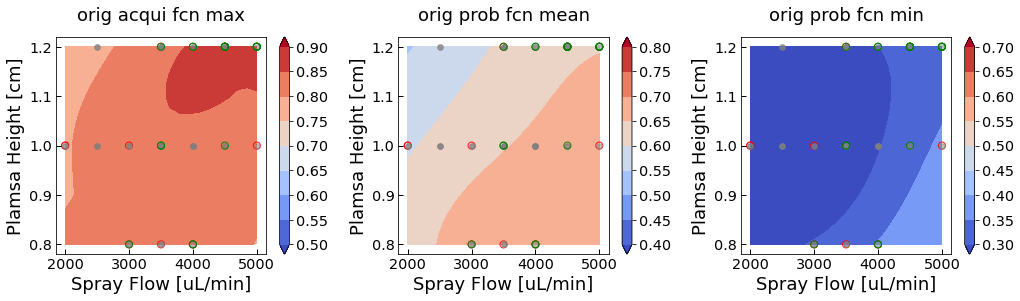

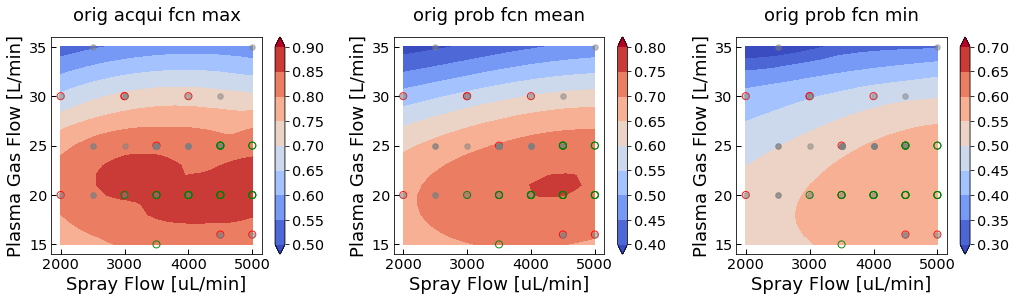

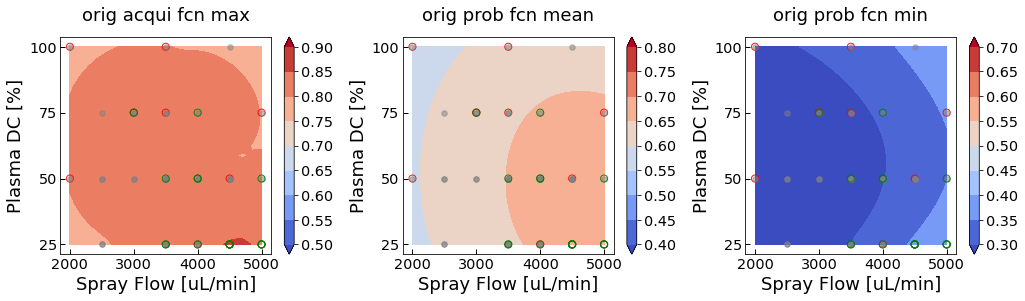

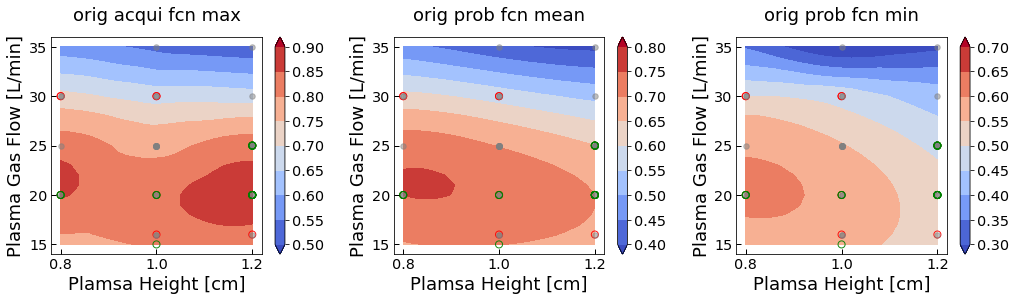

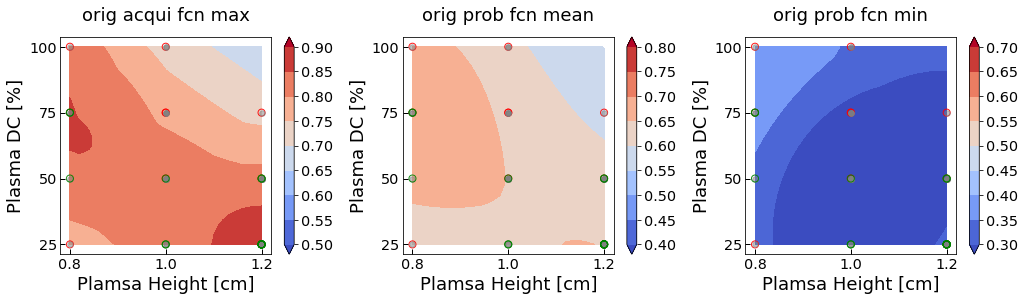

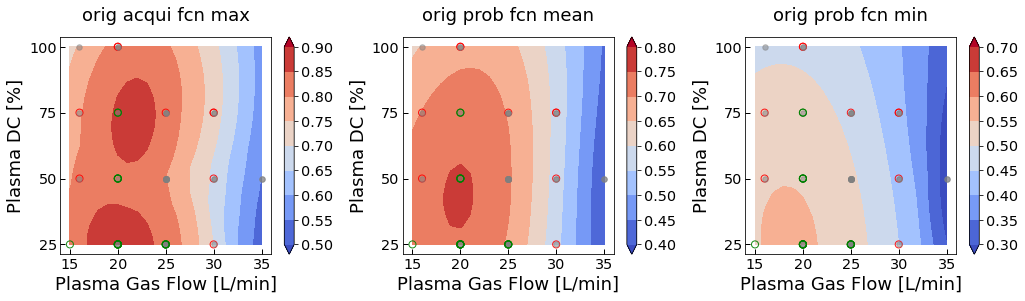

In [30]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_raw_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.4, 0.3]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y/22,levels = np.arange(9)*0.05+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                   x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                   s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter(x_denormalizer(Xc)[:, ind1], 
                       x_denormalizer(Xc)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')

            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:#Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1==1:#Speed
                ax.set_xticks([100, 150, 200, 250, 300])
            if ind1==4:#PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2==5:#PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            #axes[i].grid(True, linestyle='-.')

        axes[0].set_title('orig acqui fcn max', pad = title_pad, fontsize = fs)
        axes[1].set_title('orig prob fcn mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('orig prob fcn min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()

##### Probability Function of the Constraint

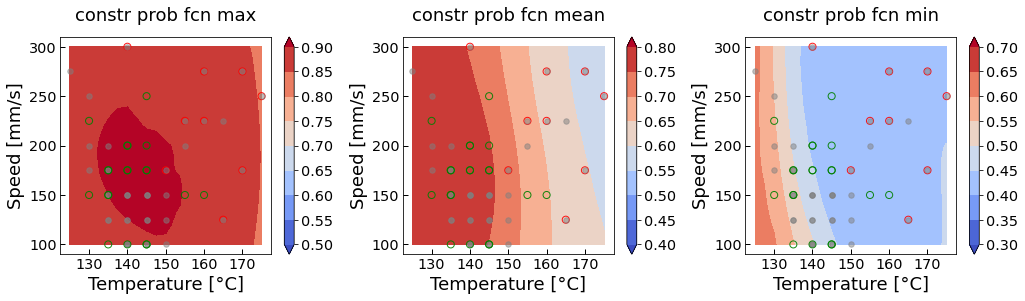

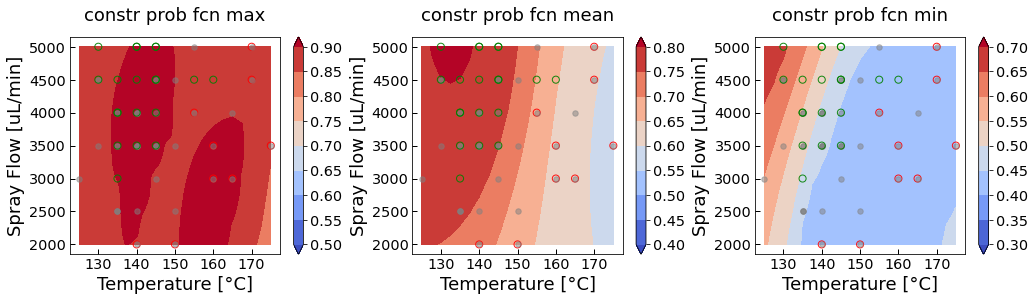

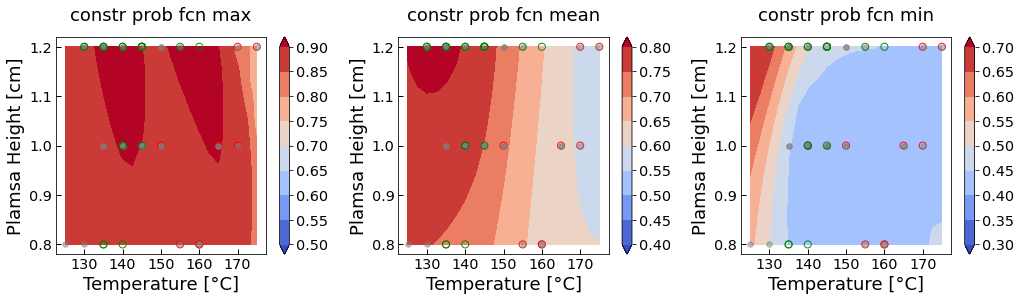

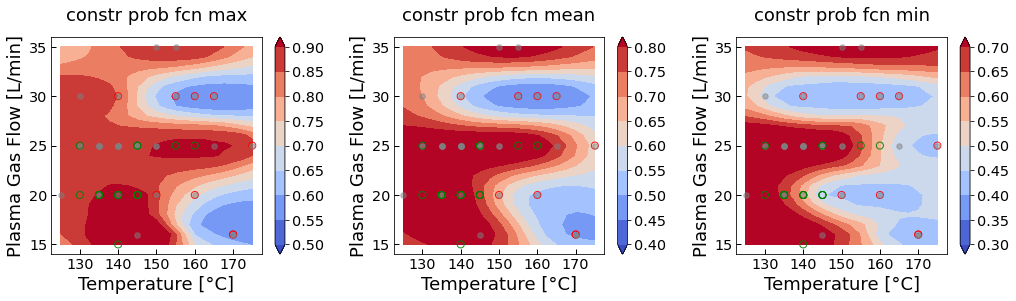

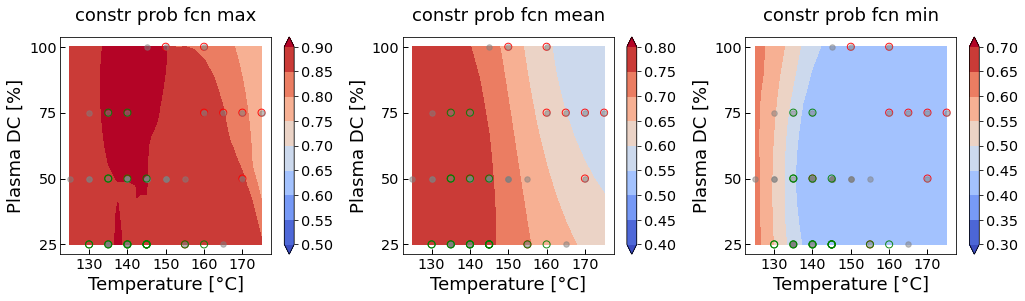

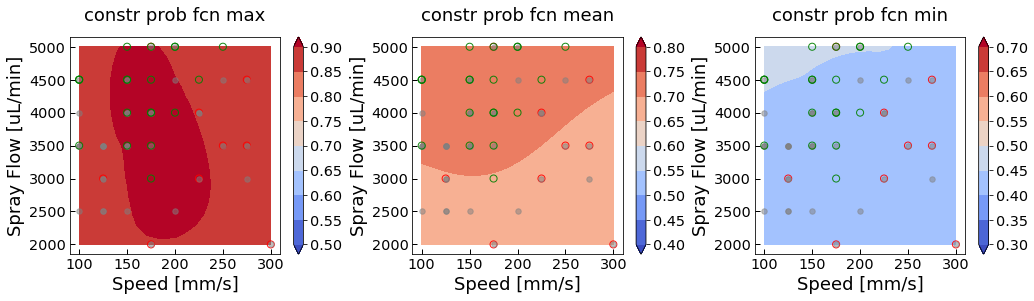

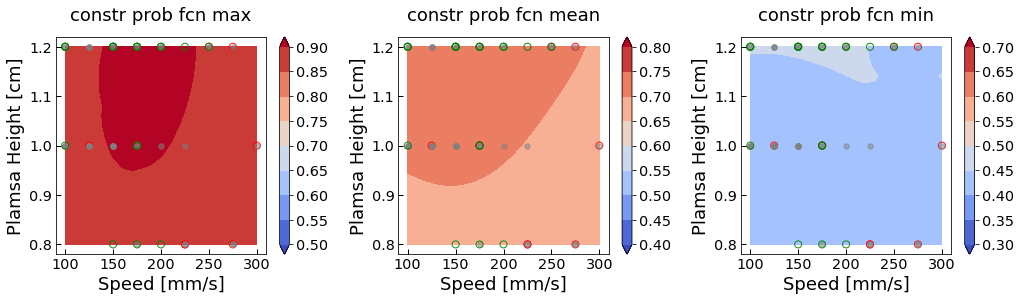

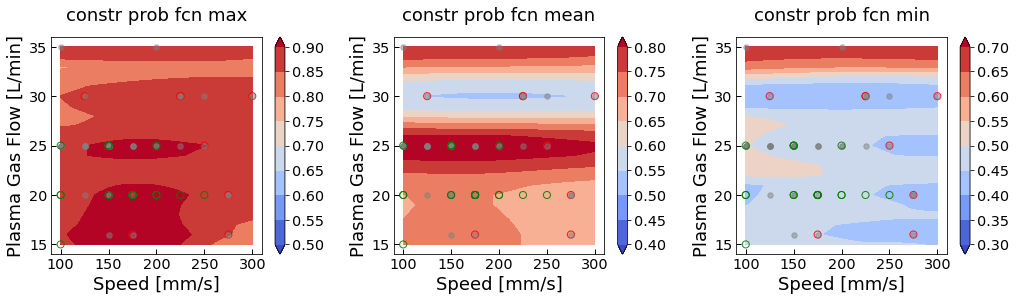

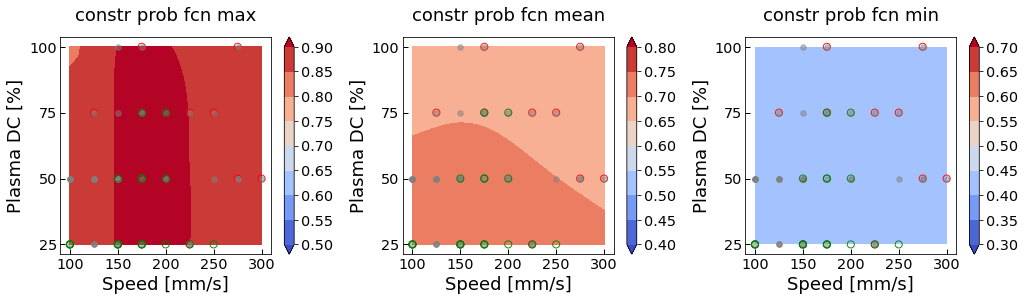

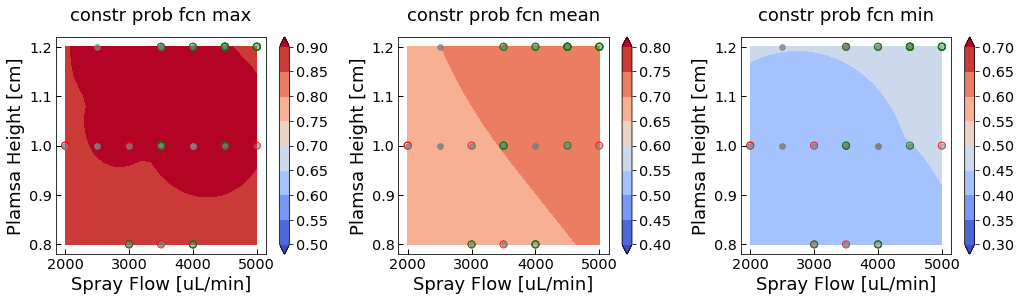

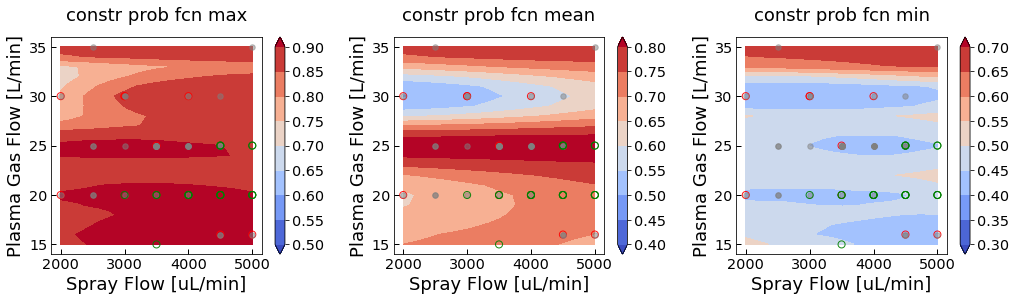

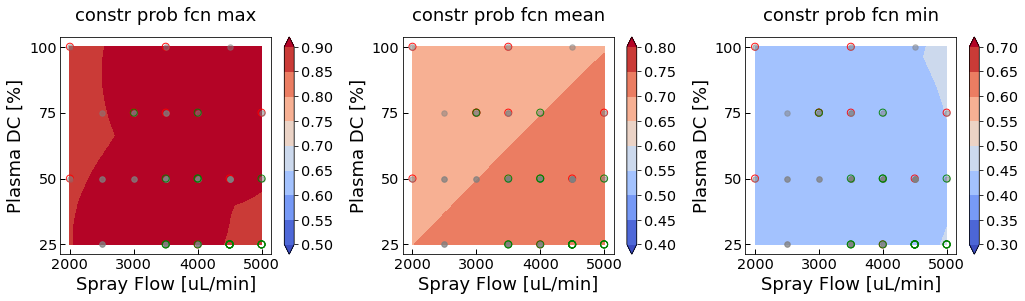

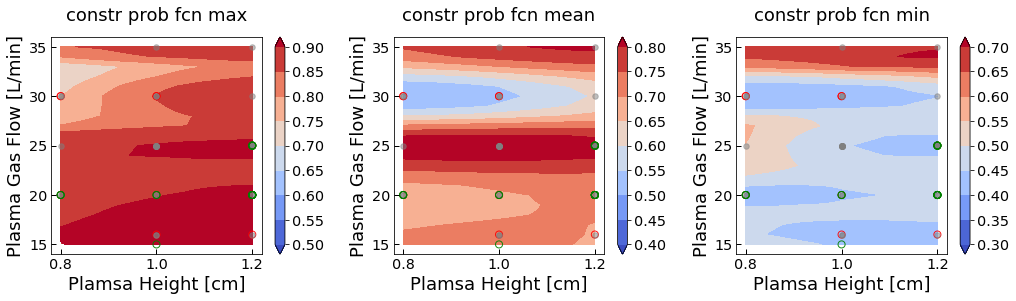

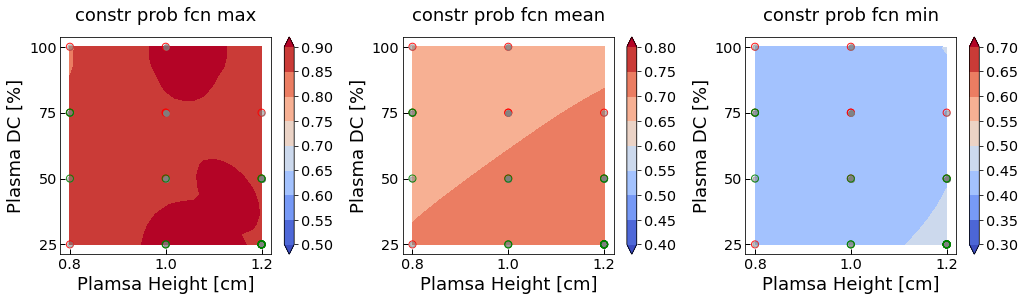

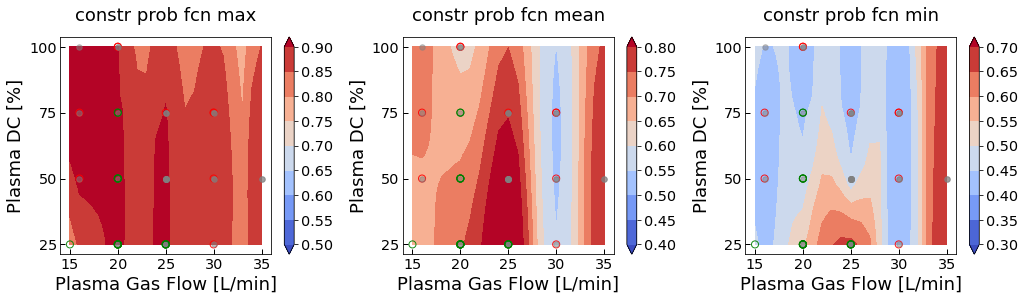

In [31]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:,1:-2].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_cons_pr(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.4, 0.3]
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y,levels = np.arange(9)*0.05+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], 
                   x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
                   s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter(x_denormalizer(Xc)[:, ind1], 
                       x_denormalizer(Xc)[:, ind2], 
                       s = 30, facecolors='gray', alpha = 0.5, edgecolor = 'gray')
            ax.scatter(x_denormalizer(X_new)[:, ind1], 
                       x_denormalizer(X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')

            ax.set_xlabel(str(x_columns[ind1]), fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:#Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1==1:#Speed
                ax.set_xticks([100, 150, 200, 250, 300])
            if ind1==4:#PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2==5:#PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            #axes[i].grid(True, linestyle='-.')

        axes[0].set_title('constr prob fcn max', pad = title_pad, fontsize = fs)
        axes[1].set_title('constr prob fcn mean', pad = title_pad, fontsize = fs)
        axes[2].set_title('constr prob fcn min', pad = title_pad, fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()